# <center> **PROJET MACHINE LEARNING** </center>
# <center>***«260 BIRD SPECIES »***       </center>                                                                   
                                                                                    Belkhir Ryan & Papereux Salomé 


# Préparation du code

In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import random
from tqdm.notebook import tqdm
import time
import os
import copy
import numpy as np
from PIL import Image
import cv2
import glob 
import splitfolders

import torch
from torchvision import datasets, models, transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

import pandas as pd
import seaborn as sn
import itertools

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import v_measure_score, homogeneity_score, classification_report, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

Afin d'augmenter les performances de nos réseaux de neurones, nous allons réaliser les calculs sur le GPU (s'il est disponible). De plus, on fixe l'aléatoire à l'aide d'une seed afin de retomber sur les mêmes résultats.

In [2]:
# Mise du code sur GPU si disponible
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print('GPU')
else:
    device = torch.device('cpu')
    print("CPU")


#Seeding
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

GPU


# Initialisation des données 

A l'aide de splitfolders, on sépare les données en 3 sets :
 - Training Set : 70% des données
 - Validation Set : 15% des données
 - Test Set : 15% des données

N.B: Les fichiers train, val et test présents dans le .zip de notre projet ont été obtenus grâce à la fonction suivante.

In [3]:
#Séparation du fichier "Consolidated" en 3 sous-fichiers Train/Test/Validation

#splitfolders.ratio("consolidated", output="dataset_split", seed=1337, ratio=(.7, .15, .15), group_prefix=None) # default values

On charge ensuite les images présentes dans chaque fichier dans un Dataloader Pytorch associé. Les images sont regroupées par Batch de 32.

In [4]:
#Création des set de Train/Test/Validation en Tensors

BATCH_SIZE = 32 
path = 'dataset_split'

data_transforms = {'train': transforms.Compose([
                       transforms.ToTensor()
                    ]),
                   'val':  transforms.Compose([
                       transforms.ToTensor()
                    ]),
                   'test': transforms.Compose([
                       transforms.ToTensor()
                    ])
                      }


# Tensor contenant les images
images_dataset = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

# Itérateur sur images_dataset
dataloaders = {x: torch.utils.data.DataLoader(images_dataset[x], batch_size = BATCH_SIZE, 
                                              shuffle =True, num_workers = 0)
                  for x in ['train', 'val', 'test']}

# Tailles des différents datasets
dataset_sizes = {x: len(images_dataset[x]) for x in ['train', 'val', 'test']}
print("Les tailles des datasets respectifs sont : \n\n", dataset_sizes)

# Liste contenant les noms des classes 
class_names = images_dataset['train'].classes

Les tailles des datasets respectifs sont : 

 {'train': 27323, 'val': 5757, 'test': 6129}


On réalise ensuite un histogramme sur la répartition de nos données :

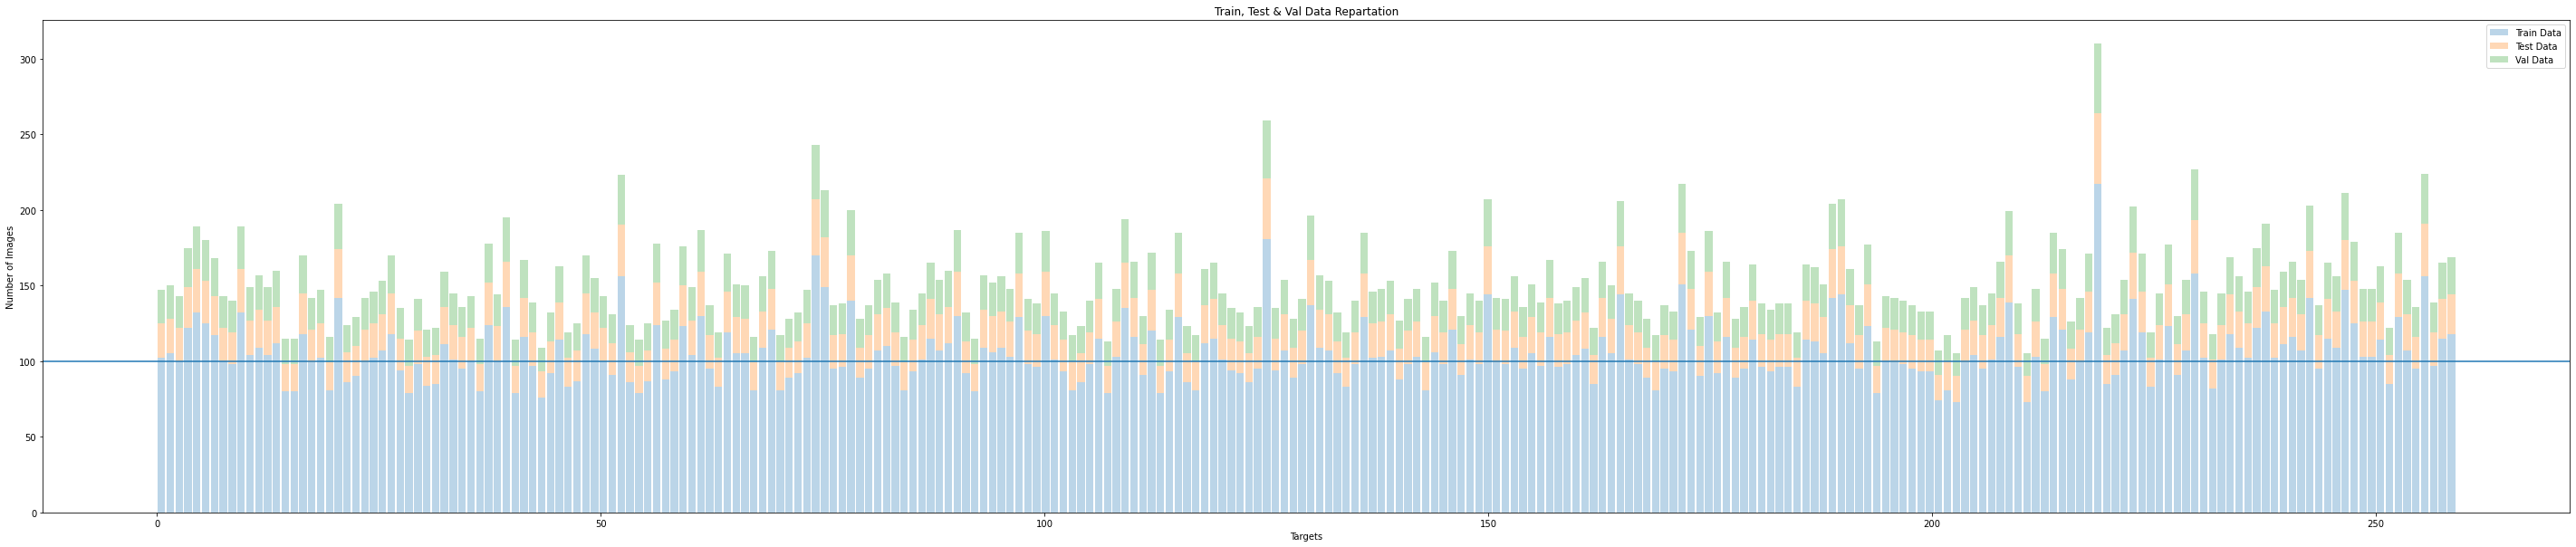

On a une moyenne de 105 oiseaux par classe
Avec un écart type de 21.21


In [5]:
# Distribution des données dans les sets de Test/Train/Validation  
# Double - clique pour un meilleur aperçu de l'histogramme

plt.figure(figsize=(50,10))
plt.hist([images_dataset['train'].targets, images_dataset['test'].targets ,images_dataset['val'].targets], bins = 260 , alpha=0.3, rwidth=0.85 #color = ['yellow', 'green']
            , label = ['Train Data','Test Data','Val Data'],
            histtype = 'barstacked')

plt.xlabel('Targets')
plt.ylabel('Number of Images')
plt.title('Train, Test & Val Data Repartation')
plt.axhline(y=100)
plt.legend()
plt.show()


mean = np.mean(np.histogram(images_dataset['train'].targets, bins = np.arange(260))[0])
std = np.std(np.histogram(images_dataset['train'].targets, bins = np.arange(260))[0])
print('On a une moyenne de {} oiseaux par classe'.format(round(mean)))
print('Avec un écart type de {}'.format(round(std,2)))

On définit la fonction *imshow()* qui va nous permettre d'afficher les images de notre Dataset :
   - **Data** : le tensor d'un des dataloaders que l'on souhaite afficher
   - **norm** : booléen qui permet, si on le souhaite, d'annuler la normalisation d'une image pour l'afficher normalement
   - **title** : titre que l'on souhaite donner à notre image

In [6]:
#Affichage d'image du dataset

def imshow(data, norm = False, title = None):
    #On arrange les colonnes avec d'avoir le bon format L x H x RGB
    data = data.numpy().transpose((1,2,0))
    
    #Si l'image est normalisée on peut choisir de l'afficher normalement ou comme étant normalisée
    if norm:
        mean = np.array([0.47143692, 0.46903405, 0.4011176 ])
        std = np.array([0.2028469,  0.20022115, 0.20570515])
        data = data * std + mean
        
    data = np.clip(data, 0, 1)
    plt.imshow(data)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

On affiche ensuite quelques images de notre dataset afin d'avoir un aperçu de ce dernier. On en profite pour afficher la taille de nos images.

Images shape on batch size = torch.Size([32, 3, 224, 224])
Labels shape on batch size = torch.Size([32])


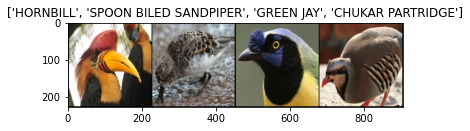

In [7]:
images, classes = next(iter(dataloaders['train']))
print('Images shape on batch size = {}'.format(images.size()))
print('Labels shape on batch size = {}'.format(classes.size()))
 
grid = torchvision.utils.make_grid(images[:4])   

imshow(grid, title = [class_names[x] for x in classes[:4]])

## Création des data set normalisés

Afin de normaliser nos données, on réalise le calcule de la moyenne et de la variance pour chacun des 3 canaux RGB sur l'ensemble de notre train set.

In [8]:
#Calcul de la moyenne et de la variance des données pour la normalisation
data_mean = []
data_std = []

for i, (image, label) in enumerate(dataloaders['train']):
    # shape (batch_size, 3, height, width)
    numpy_image = image[0].numpy()
    
    # shape (3,)
    image_mean = np.mean(numpy_image, axis=(1,2))
    image_std = np.std(numpy_image, axis=(1,2))
    
    data_mean.append(image_mean)
    data_std.append(image_std)

# shape (num_iterations, 3) -> (mean across 0th axis) -> shape (3,)
data_mean = np.array(data_mean).mean(axis=0)
data_std = np.array(data_std).mean(axis=0)

print(data_mean)
print(data_std)

[0.46925712 0.46977383 0.39990634]
[0.2047585  0.20090853 0.20577735]


Une fois la moyenne et la variance obtenues, on normalise nos données que l'on va stocker dans 3 nouveaux dataloaders Pytorch :

In [9]:
#Normalisation
IMG_SIZE = 224

#data_mean = [0.47408023, 0.46853074, 0.39888346]
#data_std = [0.20120913, 0.19721287, 0.20016192]
data_transforms = {'train': transforms.Compose([
                    transforms.Resize([IMG_SIZE,IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std)
                  ]),
                  'val': transforms.Compose([
                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std)
                  ]),
                  'test': transforms.Compose([
                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std) 
                  ]) 
                 }


images_dataset_norm = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}
dataloaders_norm = {x: torch.utils.data.DataLoader(images_dataset_norm[x], batch_size=BATCH_SIZE,
                                                   shuffle=True,  num_workers=0)
                    for x in ['train', 'val', 'test']}



On affiche quelques images de notre dataset en version normalisé et non normalisés :

Images shape on batch size = torch.Size([32, 3, 224, 224])
Labels shape on batch size = torch.Size([32])


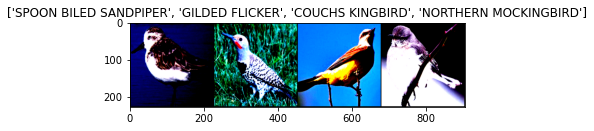

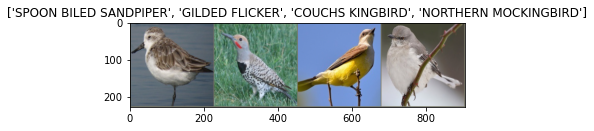

In [10]:
#Affichage d'image du dataset
images, classes = next(iter(dataloaders_norm['train']))


print('Images shape on batch size = {}'.format(images.size()))
print('Labels shape on batch size = {}'.format(classes.size()))
 
grid = torchvision.utils.make_grid(images[:4])

imshow(grid, title = [class_names[x] for x in classes[:4]])
imshow(grid, norm = True, title = [class_names[x] for x in classes[:4]])


## Création de nos réseaux de neurones

Avant toute chose, on commence par définir la fonction qui va nous permettre d'entrainer nos réseaux de neurones *train_model()* :
   - **model** : le modèle que l'on souhaite entrainer
   - **criterion** : sur quel critère on souhaite optimiser notre modèle
   - **optimizer** : méthode d'optimisation utilisée afin d'optimiser le critère
   - **scheduler** : learning rate dégréssif en fonction du nombre d'epoch
   - **nb_epochs** : le nombre de fois que l'on va passer nos données dans le modèle
   - **dataloaders** : sur quelles données nous souhaitons entraîner le modèle
  
La fonction renvoie :
   - **model** : le meilleur modèle qu'elle a croisé durant l'apprentissage
   - **history** : l'historique des accuracy et des loss obtenu durant l'apprentissage
   
N.B: La fonction affiche la durée de l'entrainement et plot l'historique des accuracy et de la loss en fonction du nombre d'epoch.

In [11]:
def train_model(model, criterion, optimizer, scheduler, nb_epochs= 8, dataloaders = dataloaders_norm):
    
    history = {'accuracy': [],
               'loss': []}
    
    training_acc = []
    training_loss = []
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(nb_epochs):
        print('Epoch {}/{} LR:{}'.format(epoch+1, nb_epochs, scheduler.get_last_lr()))
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            #tqdm
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                history['accuracy'].append(epoch_acc)   
                history['loss'].append(epoch_loss)
                
            if phase == 'train':
                training_acc.append(epoch_acc)
                training_loss.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()          

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    plt.plot(np.arange(1,nb_epochs + 1), training_acc, color = '#5A63E7', label = 'Training Accuracy')
    plt.plot(np.arange(1,nb_epochs + 1), history['accuracy'], color = '#C5B1E9',label = 'Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(np.arange(1,nb_epochs + 1), training_loss, color = '#5A63E7', label = 'Training Loss')
    plt.plot(np.arange(1,nb_epochs + 1), history['loss'], color = '#C5B1E9', label = 'Validation Loss')
    plt.legend()
    plt.show()
    
    return model, history

On définit la fonction *accu()* qui va nous permettre de calculer l'accuracy de notre modèle sur le test set une fois l'apprentissage terminé :

   - **model** : modèle que pour lequel on souhaite obtenir l'accuracy
   - **plt_cm** : booléen désignant si l'on souhaite ou non afficher la matrice de confusion de notre modèle
   - **dataloaders** : données sur lequelles on souhaite calculer l'accuracy
  
La fonction renvoie : 
   - **accuracy** : l'accuracy de notre model
   - **errors** : si plt_cm est *True*, la fonction renvoie aussi les erreurs que le modèle a commises

In [12]:
def accu(model, plt_cm = False, dataloaders = dataloaders_norm):
        
    model.eval()
    running_corrects = 0.0
    y_pred = []
    y = []
    
    errors = []
    
    classes_corrects = [0 for c in range(260)]
    classes_totals = [0 for c in range(260)]
    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            if plt_cm:
                
                for i in range(len(labels)):
                    label = labels[i]
                    pred = preds[i]
                    
                    y_pred.append(pred.cpu().numpy())
                    y.append(label.cpu().numpy())
                    
                    if label == pred:
                        classes_corrects[label] +=1
                        
                    else:
                        false_pred = (pred.cpu().numpy(), label.cpu().numpy())
                        errors.append(false_pred)
                        
                    classes_totals[label] += 1
     
        accuracy = running_corrects / dataset_sizes['test']

        if plt_cm:
            
            cm = confusion_matrix(y, y_pred, normalize = 'true')
            cm = pd.DataFrame(cm, index = [i for i in class_names],
                                  columns = [i for i in class_names])

            plt.figure(figsize=(50,50))
            sn.heatmap(cm)
            classes_accuracy = np.array(classes_corrects) / np.array(classes_totals)
            #print('Accuracy on test set: {}, Accuracy per class: {}'.format(accuracy, classes_accuracy))

            return accuracy, errors
        
        print('Accuracy on test set: {}'.format(accuracy))
        
        return accuracy 


On définit la fonction *set_parameter_requires_grad()* qui va nous permettre de freeze les premières couches du modèle sur lequel on souhaite réaliser le transfer learning :
   - **model** : Modèle que l'on souhaite utiliser pour le transfer learning
   - **features_extracting** : Booléen si on souhaite ou non freeze les premières couches

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

Dictionnaires afin de stocker en mémoire nos modèles et leurs historiques d'apprentissage en fonction des différentes modifications que l'on effectuera sur notre dataset :

In [14]:
MLP = {}
Cnn = {}
ResNet = {}
DenseNet = {}
GoogleNet = {}

history_MLP = {}
history_Cnn = {}
history_ResNet = {}
history_DenseNet = {}
history_GoogleNet = {}

## Multi Layer Perceptron

On définit notre premier réseau de neurone, un MLP constitué de :
 - 3 hiddens layers de tailles respectives : 520, 1024 et 512
 - d'une activation ReLU après chaque layers sauf le dernier
 - de 2 dropout afin de limiter le sur-apprentissage

In [60]:
#Neural Network creation
class MultiLayerPerceptron(nn.Module):   
    def __init__(self):
        super(MultiLayerPerceptron, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*IMG_SIZE*IMG_SIZE , 520),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(520, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512, 260)
        )

    # Defining the forward pass    
    def forward(self, x):
        return self.layers(x)


On entraine notre réseau de neurone, sur le dataset normalisé, en utilisant comme critère la CrossEntropy et comme méthode d'optimisation la Descente de Gradient Stochastique. On utilisera comme learning rate un scheduler qui débutera à 0.001 et sera divisé par 10 toutes les 4 epochs.

N.B : Dans tout le reste de notre projet nous utiliserons la CrossEntropy comme critère et la Descente de Gradient Stochastique comme méthode d'optimisation. Ce sont celles qui nous ont permit d'obtenir les meilleurs résultats.

N.B': De même, les learning rate sont ceux qui nous ont permit d'obtenir les meilleurs résultats.

Epoch 1/8 LR:[0.001]
--------------------
train Loss: 5.2525 Acc: 0.0253
val Loss: 4.7835 Acc: 0.0565

Epoch 2/8 LR:[0.001]
--------------------
train Loss: 4.5914 Acc: 0.0772
val Loss: 4.3291 Acc: 0.1131

Epoch 3/8 LR:[0.001]
--------------------
train Loss: 4.1907 Acc: 0.1281
val Loss: 4.0880 Acc: 0.1511

Epoch 4/8 LR:[0.001]
--------------------
train Loss: 3.9101 Acc: 0.1684
val Loss: 3.9192 Acc: 0.1758

Epoch 5/8 LR:[0.0001]
--------------------
train Loss: 3.4610 Acc: 0.2470
val Loss: 3.7626 Acc: 0.2077

Epoch 6/8 LR:[0.0001]
--------------------
train Loss: 3.3466 Acc: 0.2606
val Loss: 3.7293 Acc: 0.2150

Epoch 7/8 LR:[0.0001]
--------------------
train Loss: 3.2738 Acc: 0.2753
val Loss: 3.7059 Acc: 0.2196

Epoch 8/8 LR:[0.0001]
--------------------
train Loss: 3.2182 Acc: 0.2897
val Loss: 3.6942 Acc: 0.2244

Training complete in 12m 31s
Best val Acc: 0.224422


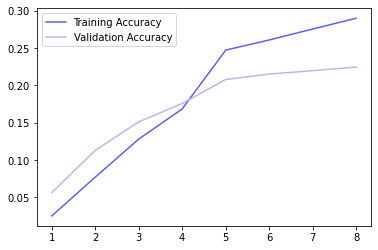

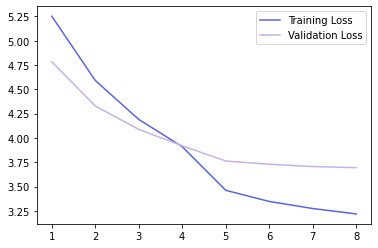

Accuracy on test set: 0.21553270518779755


tensor(0.2155, device='cuda:0')

In [61]:
#Définition du modèle
mlp = MultiLayerPerceptron()
mlp.to(device)

#Définition des critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size =4, gamma = 0.1)

#Entrainement de notre modèle
MLP['norm'], history_MLP['norm'] = train_model(mlp, criterion, optimizer, lr_scheduler)
MLP['norm'].to(device)

#Accuracy sur le test set
accu(MLP['norm'])

## Creation de notre réseau de convolution

On définit notre réseau de convolution CNN constitué de :
 - 4 couches de convolutions sur lesquelles on effectue respectivement:
  - un batchnorm : permettant de normaliser les données par batch afin de converger plus rapidement et limiter le sur-apprentissage
  - une ReLU
  - un maxpooling
 - 4 couches linéaires sur lesquelles on effectue respectivement:
  - une ReLU
  - 2 couches sont suivies d'un dropout afin de limiter le sur-apprentissage un peu plus
  

In [17]:
class CNN (Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,64,5)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64,128,5)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256,5)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256,256,5)
        self.batchnorm4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256*10*10,1600)
        self.fc2 = nn.Linear(1600,3200)
        self.fc3 = nn.Linear(3200,260)
        
    # Defining the forward pass    
    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = x.view(-1, 256*10*10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

Enfin on entraine notre réseau de convolution sur le dataset normalisé : 

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 4.7036 Acc: 0.0679
val Loss: 3.9328 Acc: 0.1612

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 3.6585 Acc: 0.1959
val Loss: 2.9946 Acc: 0.3170

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 2.9127 Acc: 0.3272
val Loss: 2.5073 Acc: 0.4138

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 2.3554 Acc: 0.4366
val Loss: 2.0693 Acc: 0.5116

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 1.6022 Acc: 0.5932
val Loss: 1.7154 Acc: 0.5921

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 1.4399 Acc: 0.6305
val Loss: 1.6574 Acc: 0.6073

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 1.3435 Acc: 0.6520
val Loss: 1.6196 Acc: 0.6133

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 1.2517 Acc: 0.6710
val Loss: 1.5812 Acc: 0.6243

Training complete in 42m 17s
Best val Acc: 0.624283


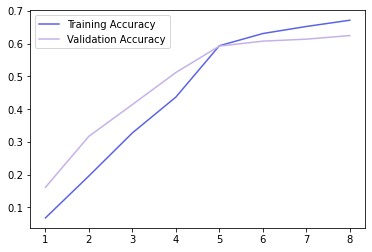

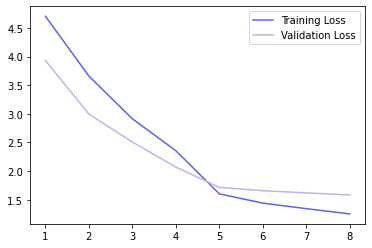

Accuracy on test set: 0.6289770007133484


tensor(0.6290, device='cuda:0')

In [63]:
#Définition de notre modèle
cnn = CNN()
cnn.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de notre modèle
Cnn['norm'], history_Cnn['norm'] =  train_model(cnn, criterion, optimizer, lr_scheduler)
Cnn['norm'].to(device)

#Accuracy sur le test set
accu(Cnn['norm'])

On affiche un comparatif entre notre modèle MLP et notre CNN :

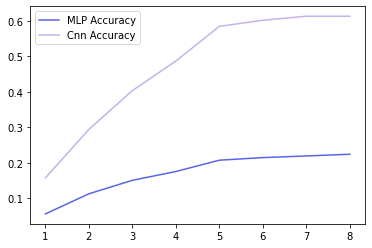

In [47]:
n = len(history_Cnn['norm']['accuracy'])

plt.plot(np.arange(1,n+1), history_MLP['norm']['accuracy'], color ='#5A63E7',label = 'MLP Accuracy')
plt.plot(np.arange(1,n+1), history_Cnn['norm']['accuracy'], color ='#C5B1E9',label = 'Cnn Accuracy')

plt.legend()
plt.show()

# Transfer Learning

## Res Net 18 

On télécharge le modèle ResNet18 pré-entrainé et on freeze les premières couches afin d'entrainer les dernières avec notre dataset normalisé :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 2.0532 Acc: 0.6100
val Loss: 0.8317 Acc: 0.8299

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.6699 Acc: 0.8638
val Loss: 0.6234 Acc: 0.8539

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.4752 Acc: 0.9024
val Loss: 0.5516 Acc: 0.8649

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.3790 Acc: 0.9200
val Loss: 0.5098 Acc: 0.8748

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.2807 Acc: 0.9507
val Loss: 0.4556 Acc: 0.8900

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.2689 Acc: 0.9536
val Loss: 0.4554 Acc: 0.8900

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.2663 Acc: 0.9553
val Loss: 0.4521 Acc: 0.8907

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.2647 Acc: 0.9535
val Loss: 0.4465 Acc: 0.8933

Training complete in 12m 26s
Best val Acc: 0.893347


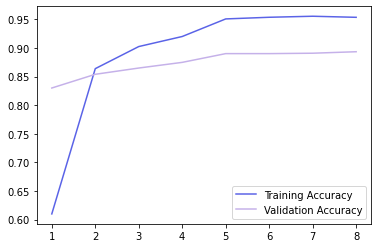

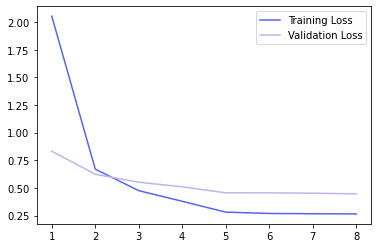

Accuracy on test set: 0.8954152464866638


tensor(0.8954, device='cuda:0')

In [64]:
#Téléchargement du modèle ResNet18
resNet18 = torchvision.models.resnet18(pretrained = True)
nb_features = resNet18.fc.in_features

#On freeze les premières couches
set_parameter_requires_grad(resNet18, True)

#On modifie la dernière couche à entrainer afin de l'adapter à notre modèle
resNet18.fc = nn.Linear(nb_features, 260)
resNet18.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#On entraine le réseau ResNet sur notre dataset normalisé
ResNet['norm'], history_ResNet['norm'] = train_model(resNet18, criterion, optimizer, lr_scheduler)
ResNet['norm'].to(device)

#On calcule l'accuracy sur le test set
accu(ResNet['norm'])


### DENSENET

On télécharge le modèle DenseNet pré-entrainé et on freeze les premières couches afin d'entrainer les dernières avec notre dataset normalisé :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 1.6008 Acc: 0.7285
val Loss: 0.5007 Acc: 0.9071

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.3642 Acc: 0.9405
val Loss: 0.3545 Acc: 0.9239

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.2313 Acc: 0.9636
val Loss: 0.3019 Acc: 0.9352

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.1690 Acc: 0.9761
val Loss: 0.2782 Acc: 0.9380

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.1199 Acc: 0.9881
val Loss: 0.2544 Acc: 0.9451

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.1163 Acc: 0.9889
val Loss: 0.2518 Acc: 0.9462

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.1131 Acc: 0.9888
val Loss: 0.2541 Acc: 0.9458

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.1118 Acc: 0.9896
val Loss: 0.2469 Acc: 0.9460

Training complete in 45m 4s
Best val Acc: 0.946153


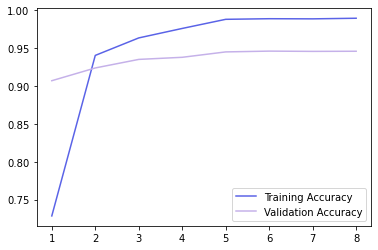

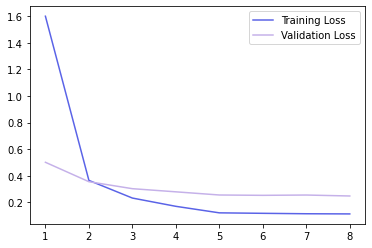

Accuracy on test set: 0.944689154624939


tensor(0.9447, device='cuda:0')

In [32]:
#Téléchargement du modèle DenseNet pré-entrainé
densenet = models.densenet161(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(densenet, True)

#On adapte le modèle à notre problème
densenet.classifier = nn.Linear(2208, 260)
densenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement du modèle DenseNet sur notre dataset normalisé
DenseNet['norm'], history_DenseNet['norm'] = train_model(densenet, criterion, optimizer, lr_scheduler)
DenseNet['norm'].to(device)

#Calcul de l'accuracy sur le test set
accu(DenseNet['norm'])



### GoogleNet

On télécharge le modèle GoogleNet pré-entrainé et on freeze les premières couches afin d'entrainer les dernières avec notre dataset normalisé :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 3.2866 Acc: 0.4506
val Loss: 1.7453 Acc: 0.7297

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 1.4459 Acc: 0.7649
val Loss: 1.0990 Acc: 0.8053

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 1.0111 Acc: 0.8200
val Loss: 0.8888 Acc: 0.8331

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.8203 Acc: 0.8462
val Loss: 0.7756 Acc: 0.8447

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.7124 Acc: 0.8727
val Loss: 0.7414 Acc: 0.8598

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.6948 Acc: 0.8777
val Loss: 0.7321 Acc: 0.8607

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.6852 Acc: 0.8771
val Loss: 0.7312 Acc: 0.8619

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.6769 Acc: 0.8792
val Loss: 0.7255 Acc: 0.8617

Training complete in 13m 31s
Best val Acc: 0.861907


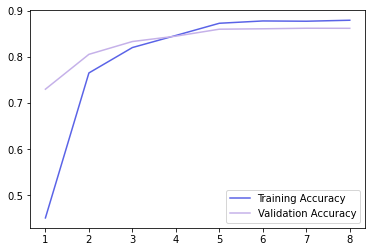

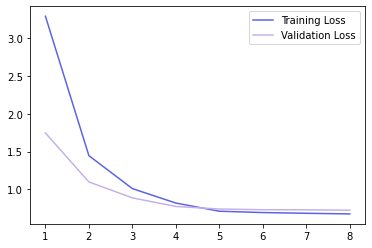

Accuracy on test set: 0.8490781188011169


tensor(0.8491, device='cuda:0')

In [65]:
#On télécharge le modèle Google pré-entrainé
googlenet = models.googlenet(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(googlenet, True)

#On adapte le modèle à notre problème
googlenet.fc = nn.Linear(1024, 260)
googlenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de notre modèle GoogleNet sur le dataset normalisé
GoogleNet['norm'], history_GoogleNet['norm'] = train_model(googlenet, criterion, optimizer, lr_scheduler)
GoogleNet['norm'].to(device)

#On calcul l'accuracy sur le test set
accu(GoogleNet['norm'])

On affiche un comparatif entre les 3 modèles utilisés : 

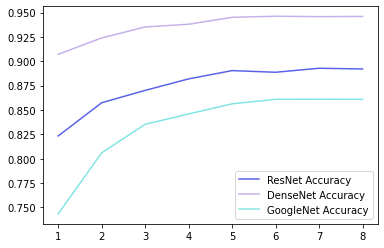

In [44]:
n = len(history_Cnn['norm']['accuracy'])

plt.plot(np.arange(1,n+1), history_ResNet['norm']['accuracy'], color ='#5A63E7',label = 'ResNet Accuracy')
plt.plot(np.arange(1,n+1), history_DenseNet['norm']['accuracy'], color ='#C5B1E9',label = 'DenseNet Accuracy')
plt.plot(np.arange(1,n+1), history_GoogleNet['norm']['accuracy'], color ='#82E5E3',label = 'GoogleNet Accuracy')

plt.legend()
plt.show()

# Extraction de features

Afin de procéder à l'extraction de feature, on définit une classe *Identity()* qui va nous permettre de récuperer l'avant dernière couche des réseaux pré-entrainé :

In [115]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

On définit la fonction *features_extraction()* qui va nous permettre de récuperer les features de nos données en fonction d'un modèle pré-entrainé et d'un dataset :
   - **model** : modèle pré-entrainé servant à l'extraction de features
   - **dataloaders** : données dont on souhaite extraire les features
   
La fonction renvoie :
   - **X** : Les features correspondant aux images
   - **y** : Les classes associées aux features

In [116]:
def features_extraction(model, dataloaders = dataloaders_norm):
       
    X = {'train': [],
         'val': [],
         'test':[]}
    y = {'train':[],
         'val': [],
         'test': []}
    
    #On freeze les couches du modèle
    set_parameter_requires_grad(model, True)
    
    for phase in ['train', 'val', 'test']:
        #tqdm
        for (inputs, labels) in dataloaders[phase]:
            inputs = inputs.to(device)
            #On récupère nos features par batch
            outputs = model(inputs)

            #On récupère nos features une par une 
            for output, label in zip(outputs, labels):
                X[phase].append(output.cpu().numpy())
                y[phase].append(label.cpu().numpy())
    
        X[phase] = np.array(X[phase])
        y[phase] = np.array(y[phase])
    
    return X, y
        

### ResNet18

A l'aide de l'algorithme *features_extraction()*, on récupère les features de notre dataset à l'aide du modèle ResNet18:

In [117]:
resNet18 = torchvision.models.resnet18(pretrained = True)

#On modifie la dernière couche par une couche Identity() définit précèdemment afin de récupérer les features
resNet18.fc = Identity()
resNet18.to(device)

#On réalise l'extraction de features
X_resNet18, y_resNet18 = features_extraction(resNet18)

print('Downloading ResNet: Done!')

###  DenseNet

A l'aide de l'algorithme features_extraction, on récupère les features de notre dataset à l'aide du modèle DenseNet:

In [118]:
densenet = models.densenet161(pretrained=True)

#On modifie la dernière couche par une couche Identity() définit précèdemment afin de récupérer les features
densenet.classifier = Identity()
densenet.to(device)

#On réalise l'extraction de features
X_densenet, y_densenet = features_extraction(densenet)

print('Downloading DenseNet: Done!')

### GoogleNet

A l'aide de l'algorithme features_extraction, on récupère les features de notre dataset à l'aide du modèle GoogleNet:

In [119]:
GoogleNet = models.googlenet(pretrained=True)
#On modifie la dernière couche par une couche Identity() définit précèdemment afin de récupérer les features
GoogleNet.classifier = Identity() 
GoogleNet.to(device)

#On réalise l'extraction de features
X_GoogleNet, y_GoogleNet = features_extraction(GoogleNet) 

print('Downloading GoogleNet: Done!')

On définit la fonction *accuracy()* qui va nous permettre de calculer l'accuracy des modèles Scikit-Learn, définit comme suit :
   - **classif** : Classifieur dont on veut calculer l'accuracy
   - **X** : Données X (nos features dans le cas présent) du train set
   - **y** : Classes associées au train set
   - **X_test** : Données X_test (nos features) du test set
   - **y_test** : Classes associées au test set
   - **predict** : Booléen permettant de savoir si on renvoie les classes prédites, si *True* la fonction renvoie y_pred 
   
La fonction renvoie :
   - l'accuracy du modèle
   - **y_pred** : un vecteur contenant les classes prédites si predict est *True*

In [104]:
def accuracy(classif,X,y,X_test=None,y_test=None, predict=False):
    
    since = time.time()
    #On fit notre modèle au train set (les données provenant du dataset normalisé on ne renormalise pas)
    classif.fit(X,y)
    
    if X_test is None:
        
        y_pred= classif.predict(X) 
        time_elapsed = time.time() - since
        print('Prediction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
        return(np.sum(y==y_pred)/np.shape(y)[0])
    
    else:
        
        y_pred= classif.predict(X_test) 
        time_elapsed = time.time() - since 
        print('Prediction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
       
        if predict:    
            
            return (np.sum(y_test==y_pred)/np.shape(y_test)[0]), y_pred

        else: 
            
            return(np.sum(y_test==y_pred)/np.shape(y_test)[0])
            



## SVM

Afin d'obtenir les meilleurs hyperparamètres possibles, on effectue un GridSearch sur nos SVM :

**N.B: ATTENTION A NE PAS LANCER SAUF EN CAS DE BESOIN (l'éxecution de certains grid search peut prendre jusqu'à 6h)**

N.B' : On effectuera tous nos grid search sur le set de validation afin d'éviter toutes fuites de données

In [22]:
def grid_search_svm(X, y):
    
    pipeline = make_pipeline(SVC(tol =0.001, random_state = 1223))

    params = {
          'svc__C' : [0.001, 0.01, 0.1, 10, 100],
          'svc__kernel' : ['linear','rbf'] 
                 }

    cv_SVM = GridSearchCV(pipeline, params, scoring = 'accuracy',cv =5, n_jobs = -1, verbose = 3)
    (accu_cv_SVM, preds_SVM) = accuracy(cv_SVM, X['train'], y['train'], X['val'], y['val'], predict = True)

    print(f'Best accuracy -score: {accu_cv_SVM:.3f}\n')
    print(f'Best parameter set: {cv_SVM.best_params_}\n')
    print(f'Scores: {classification_report(y["val"], preds_SVM, target_names = class_names)}\n')
    print(f'accuracy score: {accuracy_score(y["val"], preds_SVM):.3f}')
    
    return cv_SVM


On effecute un SVM sur les features de ResNet18 avec les meilleurs paramètres obtenus lors du *grid_search()* :
   - C = 10
   - kernel = rbf

In [25]:
grid_search_svm(X_resNet18, y_resNet18)
svm_resNet18 = SVC(C = 10, kernel ='rbf')
acc_svm_resNet18 = accuracy(svm_resNet18, X_resNet18['train'], y_resNet18['train'], X_resNet18['test'], y_resNet18['test'])
print('ResNet18 Accuracy on SVM: {}'.format(acc_svm_resNet18))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Prediction complete in 48m 24s
Best accuracy -score: 0.888

Best parameter set: {'svc__C': 10, 'svc__kernel': 'rbf'}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.96      1.00      0.98        22
          AFRICAN FIREFINCH       0.74      0.77      0.76        22
                  ALBATROSS       0.78      0.86      0.82        21
       ALEXANDRINE PARAKEET       0.92      0.88      0.90        26
            AMERICAN AVOCET       0.96      0.96      0.96        28
           AMERICAN BITTERN       1.00      0.96      0.98        27
              AMERICAN COOT       0.96      0.96      0.96        25
         AMERICAN GOLDFINCH       0.94      0.76      0.84        21
           AMERICAN KESTREL       0.90      0.90      0.90        21
             AMERICAN PIPIT       0.87      0.93      0.90        28
          AMERICAN REDSTART       0.89      0.77     

Prediction complete in 4m 51s
ResNet18 Accuracy on SVM: 0.8893783651492903


On effecute un SVM sur les features de DenseNet avec les meilleurs paramètres obtenus lors du *grid_search()* :
   - C = 10
   - kernel = rbf

In [26]:
grid_search_svm(X_densenet, y_densenet)
svm_densenet = SVC(C = 10, kernel ='rbf')
acc_svm_densenet = accuracy(svm_densenet, X_densenet['train'], y_densenet['train'], X_densenet['test'], y_densenet['test'])
print('DenseNet Accuracy on SVM: {}'.format(acc_svm_densenet))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Prediction complete in 376m 15s
Best accuracy -score: 0.937

Best parameter set: {'svc__C': 10, 'svc__kernel': 'rbf'}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       1.00      1.00      1.00        22
          AFRICAN FIREFINCH       0.88      0.95      0.91        22
                  ALBATROSS       0.91      1.00      0.95        21
       ALEXANDRINE PARAKEET       1.00      0.96      0.98        26
            AMERICAN AVOCET       1.00      1.00      1.00        28
           AMERICAN BITTERN       0.96      1.00      0.98        27
              AMERICAN COOT       1.00      1.00      1.00        25
         AMERICAN GOLDFINCH       1.00      0.90      0.95        21
           AMERICAN KESTREL       0.83      0.90      0.86        21
             AMERICAN PIPIT       0.93      0.96      0.95        28
          AMERICAN REDSTART       0.83      0.91    

Prediction complete in 7m 18s
DenseNet Accuracy on SVM: 0.9370207211616903


On effecute un SVM sur les features de GoogleNet avec les meilleurs paramètres obtenus lors du grid_search :
   - C = 10
   - kernel = rbf

In [27]:
grid_search_svm(X_GoogleNet, y_GoogleNet)
svm_GoogleNet = SVC(C = 10, kernel ='rbf')
acc_svm_GoogleNet = accuracy(svm_GoogleNet, X_GoogleNet['train'], y_GoogleNet['train'], X_GoogleNet['test'], y_GoogleNet['test'])
print('GoogleNet Accuracy on SVM: {}'.format(acc_svm_GoogleNet))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Prediction complete in 99m 37s
Best accuracy -score: 0.803

Best parameter set: {'svc__C': 10, 'svc__kernel': 'rbf'}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.91      0.95      0.93        22
          AFRICAN FIREFINCH       0.48      0.73      0.58        22
                  ALBATROSS       0.95      0.86      0.90        21
       ALEXANDRINE PARAKEET       0.81      0.85      0.83        26
            AMERICAN AVOCET       0.96      0.96      0.96        28
           AMERICAN BITTERN       0.92      0.89      0.91        27
              AMERICAN COOT       0.82      0.92      0.87        25
         AMERICAN GOLDFINCH       0.89      0.81      0.85        21
           AMERICAN KESTREL       0.70      0.67      0.68        21
             AMERICAN PIPIT       0.81      0.93      0.87        28
          AMERICAN REDSTART       0.71      0.68     

Prediction complete in 3m 21s
GoogleNet Accuracy on SVM: 0.7906673193016805


## Random Forest

De même, on  définit une fonction *grid_search()* pour les Random Forest :

In [34]:
def grid_search_forest(X, y):
    
    pipeline = make_pipeline(RandomForestClassifier( random_state = 1223))
    print(pipeline)
    params = {
                'randomforestclassifier__n_estimators' : [10,30,50,100],
                'randomforestclassifier__criterion' : ['gini']
                 }

    cv_forest = GridSearchCV(pipeline, params, scoring = 'accuracy',cv =5, n_jobs = -1, verbose = 3)
    (accu_cv_forest, preds_forest) = accuracy(cv_forest, X['train'], y['train'], X['val'], y['val'], predict = True)

    print(f'Best accuracy -score: {accu_cv_forest:.3f}\n')
    print(f'Best parameter set: {cv_forest.best_params_}\n')
    print(f'Scores: {classification_report(y["val"], preds_forest, target_names = class_names)}\n')
    print(f'accuracy score: {accuracy_score(y["val"], preds_forest):.3f}')
    
    return cv_forest

On effecute un Random Forest sur les features de ResNet18 avec les meilleurs paramètres obtenus lors du grid_search :
   - n_estimators = 100


In [24]:
grid_search_forest(X_resNet18, y_resNet18)
clf_resNet18 = RandomForestClassifier(n_estimators = 100, random_state = 1223)
acc_forest_resNet18 = accuracy(clf_resNet18, X_resNet18['train'], y_resNet18['train'], X_resNet18['test'], y_resNet18['test'])
print('ResNet18 Accuracy on Random Forest: {}'.format(acc_forest_resNet18))



Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=1223))])
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Prediction complete in 25m 26s
Best accuracy -score: 0.695

Best parameter set: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 100}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.81      1.00      0.90        22
          AFRICAN FIREFINCH       0.42      0.50      0.46        22
                  ALBATROSS       0.59      0.81      0.68        21
       ALEXANDRINE PARAKEET       0.49      0.65      0.56        26
            AMERICAN AVOCET       0.78      0.89      0.83        28
           AMERICAN BITTERN       0.65      0.96      0.78        27
              AMERICAN COOT       0.51      0.88      0.65        25
         AMERICAN GOLDFINCH       0.53      0.81      0.64        21
           AMERICAN KESTREL      

Prediction complete in 5m 21s
ResNet18 Accuracy on Random Forest: 0.6855930820688529


On effecute un Random Forest sur les features de DenseNet avec les meilleurs paramètres obtenus lors du grid_search :
   - n_estimators = 100

In [35]:
grid_search_forest(X_densenet, y_densenet)
clf_densenet = RandomForestClassifier(n_estimators = 100, random_state = 1223)
acc_forest_densenet = accuracy(clf_densenet, X_densenet['train'], y_densenet['train'], X_densenet['test'], y_densenet['test'])
print('DenseNet Accuracy on Random Forest: {}'.format(acc_forest_densenet))



Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=1223))])
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Prediction complete in 34m 14s
Best accuracy -score: 0.759

Best parameter set: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 100}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.88      1.00      0.94        22
          AFRICAN FIREFINCH       0.67      0.73      0.70        22
                  ALBATROSS       0.59      0.90      0.72        21
       ALEXANDRINE PARAKEET       0.58      0.96      0.72        26
            AMERICAN AVOCET       0.87      0.96      0.92        28
           AMERICAN BITTERN       0.74      0.96      0.84        27
              AMERICAN COOT       0.80      0.96      0.87        25
         AMERICAN GOLDFINCH       0.73      0.76      0.74        21
           AMERICAN KESTREL      

Prediction complete in 6m 37s
DenseNet Accuracy on Random Forest: 0.75950399738946


On effecute un Random Forest sur les features de GoogleNet avec les meilleurs paramètres obtenus lors du grid_search :
   - n_estimators = 100

In [35]:
grid_search_forest(X_GoogleNet, y_GoogleNet)
clf_GoogleNet = RandomForestClassifier(n_estimators = 100, random_state = 1223)
acc_forest_GoogleNet = accuracy(clf_GoogleNet, X_GoogleNet['train'], y_GoogleNet['train'], X_GoogleNet['test'], y_GoogleNet['test'])
print('GoogleNet Accuracy on Random Forest: {}'.format(acc_forest_GoogleNet))


Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=1223))])
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Prediction complete in 37m 12s
Best accuracy -score: 0.562

Best parameter set: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 100}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.75      0.82      0.78        22
          AFRICAN FIREFINCH       0.42      0.45      0.43        22
                  ALBATROSS       0.55      0.81      0.65        21
       ALEXANDRINE PARAKEET       0.36      0.65      0.47        26
            AMERICAN AVOCET       0.73      0.96      0.83        28
           AMERICAN BITTERN       0.71      0.93      0.81        27
              AMERICAN COOT       0.67      0.96      0.79        25
         AMERICAN GOLDFINCH       0.59      0.62      0.60        21
           AMERICAN KESTREL      

Prediction complete in 10m 20s
GoogleNet Accuracy on Random Forest: 0.5619187469407734


## KNeighbors

On définit le grid search associé au classifieur KNeighbors :

N.B : Suite à un problème de RAM, nous n'avons pas pu le lancer et avons donc trouvé des paramètres adéquats nous-même

In [26]:
def grid_search_KNN(X, y):
    
    pipeline = make_pipeline(KNeighborsClassifier())
    params = {
                'kneighborsclassifier__n_neighbors' : [3, 11, 49]
                 }

    cv_knn = GridSearchCV(pipeline, params, scoring = 'accuracy',cv =2, n_jobs = 0, verbose = 3)
    (accu_cv_knn, preds_knn) = accuracy(cv_knn, X['train'], y['train'], X['val'], y['val'], predict = True)

    print(f'Best accuracy -score: {accu_cv_knn:.3f}\n')
    print(f'Best parameter set: {cv_knn.best_params_}\n')
    print(f'Scores: {classification_report(y["val"], preds_knn, target_names = class_names)}\n')
    print(f'accuracy score: {accuracy_score(y["val"], preds_knn):.3f}')
    
    return cv_knn

On effectue un KNeighbors sur les features de ResNet avec les paramètres suivants :
   - n_neighbors = 13

In [46]:
#grid_search_KNN(X_resNet18, y_resNet18)
clf_resNet18 = KNeighborsClassifier(13)
acc_forest_resNet18 = accuracy(clf_resNet18, X_resNet18['train'], y_resNet18['train'], X_resNet18['test'], y_resNet18['test'])
print('ResNet18 Accuracy on KNeighborClassifier: {}'.format(acc_forest_resNet18))

Prediction complete in 0m 4s
ResNet18 Accuracy on KNeighborClassifier: 0.7857725566976669


On effectue un KNeighbors sur les features de DenseNet avec les paramètres suivants :
   - n_neighbors = 7

In [49]:
#grid_search_KNN(X_densenet, y_densenet)
clf_densenet = KNeighborsClassifier(7)
acc_forest_densenet = accuracy(clf_densenet, X_densenet['train'], y_densenet['train'], X_densenet['test'], y_densenet['test'])
print('DenseNet Accuracy on KNeighborClassifier: {}'.format(acc_forest_densenet))

Prediction complete in 0m 9s
DenseNet Accuracy on KNeighborClassifier: 0.882525697503671


On effectue un KNeighbors sur les features de GoogleNet avec les paramètres suivants :
   - n_neighbors = 7

In [59]:
#grid_search_KNN(X_GoogleNet, y_GoogleNet)
clf_GoogleNet = KNeighborsClassifier(7)
acc_forest_GoogleNet = accuracy(clf_GoogleNet, X_GoogleNet['train'], y_GoogleNet['train'], X_GoogleNet['test'], y_GoogleNet['test'])
print('GoogleNet Accuracy on KNeighborClassifier: {}'.format(acc_forest_GoogleNet))

Prediction complete in 0m 6s
GoogleNet Accuracy on KNeighborClassifier: 0.6350138684940447


## SGD Classifier

On définit une fonction *Grid_search()* pour les SGDClassifier :

In [26]:
def grid_search_SGD(X, y):
    
    pipeline = make_pipeline(SGDClassifier(max_iter = 1000, tol = 0.0001, random_state = 1223))
    params = {
                'sgdclassifier__loss' : ['hinge', 'log', 'perceptron']
                 }

    cv_sgd = GridSearchCV(pipeline, params, scoring = 'accuracy',cv =5, n_jobs = -1, verbose = 3)
    (accu_cv_sgd, preds_sgd) = accuracy(cv_sgd, X['train'], y['train'], X['val'], y['val'], predict = True)

    print(f'Best accuracy -score: {accu_cv_sgd:.3f}\n')
    print(f'Best parameter set: {cv_sgd.best_params_}\n')
    print(f'Scores: {classification_report(y["val"], preds_sgd, target_names = class_names)}\n')
    print(f'accuracy score: {accuracy_score(y["val"], preds_sgd):.3f}')
    
    return cv_sgd

On effectue un SGDClassifier sur les features de ResNet avec les paramètres suivants :
   - loss = log

In [27]:
grid_search_SGD(X_resNet18, y_resNet18)
sgd_clf_resNet18 = SGDClassifier(loss = 'log', max_iter = 1000, tol = 0.0001, random_state = 1223)
acc_sgd_resNet18 = accuracy(sgd_clf_resNet18, X_resNet18['train'], y_resNet18['train'], X_resNet18['test'], y_resNet18['test'])
print('ResNet18 Accuracy on SGDClassifier: {}'.format(acc_sgd_resNet18))




Fitting 5 folds for each of 3 candidates, totalling 15 fits
Prediction complete in 9m 20s
Best accuracy -score: 0.853

Best parameter set: {'sgdclassifier__loss': 'log'}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       1.00      1.00      1.00        22
          AFRICAN FIREFINCH       0.92      0.55      0.69        22
                  ALBATROSS       0.83      0.71      0.77        21
       ALEXANDRINE PARAKEET       0.88      0.81      0.84        26
            AMERICAN AVOCET       0.96      0.86      0.91        28
           AMERICAN BITTERN       1.00      0.96      0.98        27
              AMERICAN COOT       0.96      0.96      0.96        25
         AMERICAN GOLDFINCH       0.94      0.76      0.84        21
           AMERICAN KESTREL       0.86      0.90      0.88        21
             AMERICAN PIPIT       0.83      0.89      0.86        28
          AMERICAN REDSTART       0.85      0.77      0.81   

Prediction complete in 2m 10s
ResNet18 Accuracy on SGDClassifier: 0.849404470549845


On effectue un SGDClassifier sur les features de DenseNet avec les paramètres suivants :
   - loss = log

In [28]:
grid_search_SGD(X_densenet, y_densenet)
sgd_clf_densenet = SGDClassifier(loss = 'log', max_iter = 1000, tol = 0.0001, random_state = 1223)
acc_sgd_densenet = accuracy(sgd_clf_densenet, X_densenet['train'], y_densenet['train'], X_densenet['test'], y_densenet['test'])
print('DenseNet Accuracy on SGDClassifier: {}'.format(acc_sgd_densenet))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Prediction complete in 22m 55s
Best accuracy -score: 0.928

Best parameter set: {'sgdclassifier__loss': 'log'}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       1.00      1.00      1.00        22
          AFRICAN FIREFINCH       0.83      0.91      0.87        22
                  ALBATROSS       0.95      1.00      0.98        21
       ALEXANDRINE PARAKEET       1.00      0.92      0.96        26
            AMERICAN AVOCET       1.00      0.96      0.98        28
           AMERICAN BITTERN       1.00      1.00      1.00        27
              AMERICAN COOT       0.96      0.96      0.96        25
         AMERICAN GOLDFINCH       0.91      0.95      0.93        21
           AMERICAN KESTREL       0.90      0.90      0.90        21
             AMERICAN PIPIT       0.96      0.96      0.96        28
          AMERICAN REDSTART       0.86      0.82      0.84  

Prediction complete in 5m 19s
DenseNet Accuracy on SGDClassifier: 0.928699624734867


On effectue un SGDClassifier sur les features de GoogleNet avec les paramètres suivants :
   - loss = perceptron

In [35]:
grid_search_SGD(X_GoogleNet, y_GoogleNet)
sgd_clf_GoogleNet = SGDClassifier(loss = 'perceptron', max_iter = 1000, tol = 0.0001, random_state = 1223)
acc_sgd_GoogleNet = accuracy(sgd_clf_GoogleNet, X_GoogleNet['train'], y_GoogleNet['train'], X_GoogleNet['test'], y_GoogleNet['test'])
print('GoogleNet Accuracy on SGDClassifier: {}'.format(acc_sgd_GoogleNet))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Prediction complete in 27m 34s
Best accuracy -score: 0.744

Best parameter set: {'sgdclassifier__loss': 'perceptron'}

Scores:                              precision    recall  f1-score   support

      AFRICAN CROWNED CRANE       0.91      0.91      0.91        22
          AFRICAN FIREFINCH       0.50      0.55      0.52        22
                  ALBATROSS       1.00      0.71      0.83        21
       ALEXANDRINE PARAKEET       1.00      0.77      0.87        26
            AMERICAN AVOCET       0.87      0.96      0.92        28
           AMERICAN BITTERN       0.96      0.85      0.90        27
              AMERICAN COOT       0.82      0.92      0.87        25
         AMERICAN GOLDFINCH       0.71      0.71      0.71        21
           AMERICAN KESTREL       0.63      0.57      0.60        21
             AMERICAN PIPIT       0.77      0.82      0.79        28
          AMERICAN REDSTART       0.65      0.77     

Prediction complete in 4m 43s
GoogleNet Accuracy on SGDClassifier: 0.7467776146190244


## OpenCV

Dans la prochaine partie, nous allons utiliser la bibliothèque OpenCV afin de réaliser de l'extraction de features. Suite à des problèmes de temps d'éxecution, nous n'allons nous servir que de 10% du train set afin d'effectuer l'extraction de features. Afin de préserver la répartition des classes on se sert à nouveau de SplitFolder qui nous a permit de faire le fichier features_extraction présent dans le .zip :

In [ ]:
#Création d'un fichier contenant 10% du train set pour effectuer l'extraction de features
#splitfolders.ratio("dataset_split/train", output="features_extraction", seed=1337, ratio=(0.1, .45, .45), group_prefix=None) # default values

## SIFT

On commence par charger les images présentes dans le fichier extraction_features représentant 10% de notre dataset :

In [150]:
extraction_path = 'features_extraction'

filenames = {x: glob.glob(os.path.join(path, x)+ '/*/*.jpg')
             for x in ['train', 'val', 'test']}

extraction_filenames = glob.glob(extraction_path + '/*/*.jpg')
#filenames.sort()

images = {x: [cv2.imread(img) for img in filenames[x]]
             for x in ['train', 'val', 'test']}

extraction_images = [cv2.imread(img) for img in extraction_filenames]

print(len(extraction_images))

2613


On effectue ensuite une extraction de features à l'aide de l'algorithme SIFT présent dans OpenCV :

In [151]:
sift = cv2.xfeatures2d.SIFT_create(160)
#Définition du KMeans qui permettra de représenter notre dictionnaire de features
features_clf = KMeans(100, random_state = 1223)
features = np.zeros((1,128))

#On extrait les features de chacune de nos images
#tqdm
for img in extraction_images:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(img_gray,None)
    features = np.vstack((features,des))

features = np.delete(features, (0), axis=0)

#On fit l'ensemble de nos features afin d'obtenir 50 clusters
features_clf.fit(features)

print('Features Extraction with SIFT: Done!')

Features Extraction with SIFT: Done!


On affiche le résultat de notre extraction de features sur quelques images, pour avoir un aperçu du résultat :

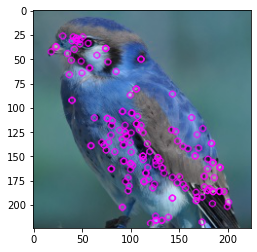

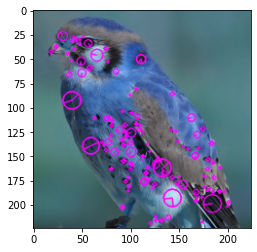

In [152]:
img = images['train'][909]

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kp, des = sift.detectAndCompute(img_gray,None)
plt.imshow(cv2.drawKeypoints(img, kp, None, (255, 0, 255)))
plt.show()
plt.imshow(cv2.drawKeypoints(img, kp, None, (255, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.show()


Maintenant que l'on a notre dictionnaire de features qui va nous permettre de définir nos images. On parcourt l'ensemble des images de notre dataset dont l'on va extraire les features  que l'on va associer à la feature la plus proche de notre dictionnaire. Enfin on va compter le nombre d'occurence des features de notre dictionnaire pour chaque image, ce qui va nous servir de nouvelle définition de notre image :

In [153]:
X_sift = {'train': [],
          'val': [],
          'test': []}

y_sift = {x: images_dataset[x].targets for x in ['train', 'val', 'test']}

#Pour toutes les images de notre dataset 
for phase in ['train', 'val', 'test']:
    #tqdm
    for img in images[phase]:
        #On extrait les features à l'aide de l'algorithme SIFT
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(img_gray,None)
        des = np.array(des, dtype=np.double)
        #On associe les features aux features de notre dictionnaire
        des = features_clf.predict(des)
        #On compte l'occurence des features de notre dictionnaire
        pred = np.histogram(des, bins = np.arange(100))
        X_sift[phase].append(pred[0])

print('SIFT: Done!')


SIFT: Done!


## SURF

De même, on va réaliser exactement la même operation que précédemment en se servant de l'algorithme SURF plutôt que SIFT, qui devrait nous permettre de trouver plus de features plus rapidemment :

In [154]:
surf = cv2.xfeatures2d.SURF_create(160)
#Définition de notre dictionnaire de features
features_clf = KMeans(100, random_state = 1223)
features = np.zeros((1,64))

#On parcourt 10% de notre train set afin d'entrainer notre dictionnaire
#tqdm
for img in extraction_images:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, des = surf.detectAndCompute(img_gray,None)
    features = np.vstack((features,des))

    
features = np.delete(features, (0), axis=0)

#On fit notre dictionnaire
features_clf.fit(features)

print('Features Extraction with SURF: Done!')

Features Extraction with SURF: Done!


Afin d'avoir un aperçu de la différence entre SIFT et SURF, on affiche quelques images avec les features associées :

N.B : On remarque en effet que l'on obtient beaucoup plus de features

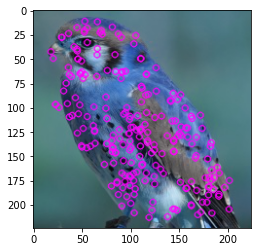

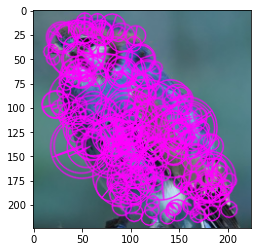

In [155]:
img = images['train'][909]

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
kp, des = surf.detectAndCompute(img_gray,None)
plt.imshow(cv2.drawKeypoints(img, kp, None, (255, 0, 255)))
plt.show()
plt.imshow(cv2.drawKeypoints(img, kp, None, (255, 0, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
plt.show()


De même que pour SIFT, on calcule le nombre d'occurence des features de notre dictionnaire dans chaque image du dataset :

In [156]:
X_surf = {'train': [],
          'val': [],
          'test': []}

y_surf = {x: images_dataset[x].targets for x in ['train', 'val', 'test']}

for phase in ['train', 'val', 'test']:
    #tqdm
    for img in images[phase]:
        #On extrait les features avec l'algorithme SURF
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp, des = surf.detectAndCompute(img_gray,None)
        des = np.array(des, dtype=np.double)
        #On associe chaque features à une feature de notre dictionnaire
        des = features_clf.predict(des)
        pred = np.histogram(des, bins = np.arange(100))
        #On compte le nombre d'occurence des features de notre dictionnaire
        X_surf[phase].append(pred[0])
        
print('SURF: Done!')


SURF: Done!


In [157]:
sift_svm = SVC(random_state = 1223)

print('Accuracy on SIFT features :', accuracy(sift_svm,X_sift['train'],y_sift['train'],X_sift['test'],y_sift['test']))

surf_svm = SVC(random_state = 1223)

print('Accuracy on SURF features:', accuracy(surf_svm,X_surf['train'],y_surf['train'],X_surf['test'],y_surf['test']))

Prediction complete in 3m 1s
Accuracy on SIFT features : 0.11845325501713166
Prediction complete in 2m 17s
Accuracy on SURF features: 0.14635340186000978


# Transformation des Datasets

Afin d'aller plus loin dans nos analyses, nous avons décidé d'effectuer des modifications sur nos dataset. Et de comparer les performances de nos modèles :

## Black & White : 

On commence tout d'abord par mettre nos images en Noir et Blanc :

N.B : Afin de pouvoir les passer dans des réseaux pré-entrainés tel que ResNet, on conserve le format des images avec 3 caneaux malgré qu'elles ne soient plus en couleur. De plus, on normalise tout de même nos images afin d'avoir une meilleure convergence.

In [66]:
data_transforms_grey = {'train': transforms.Compose([
                    transforms.Resize([IMG_SIZE,IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std),
                    transforms.Grayscale(3)
                  ]),
                  'val': transforms.Compose([
                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std),
                    transforms.Grayscale(3)
                  ]),
                  'test': transforms.Compose([
                    transforms.Resize([IMG_SIZE, IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std),
                    transforms.Grayscale(3)
                  ]) 
                 }


images_dataset_grey = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms_grey[x])
                    for x in ['train', 'val', 'test']}
dataloaders_grey = {x: torch.utils.data.DataLoader(images_dataset_grey[x], batch_size=BATCH_SIZE,
                                                   shuffle=True,  num_workers=0)
                    for x in ['train', 'val', 'test']}



On affiche les images de notre dataset en noir et blanc, en affichant quelques images en version normalisés et non normalisés.

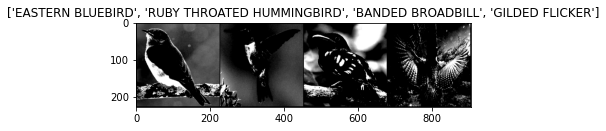

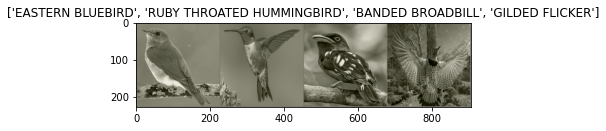

In [67]:
#Affichage d'image du dataset Noir et Blanc
images, classes = next(iter(dataloaders_grey['train']))


grid = torchvision.utils.make_grid(images[:4])

imshow(grid, title = [class_names[x] for x in classes[:4]])
imshow(grid, norm = True, title = [class_names[x] for x in classes[:4]])

# Réseaux de neurones Noir & Blanc

## Multi Layer Perceptron

On commence par entrainer notre MLP sur le dataset noir et blanc :

Epoch 1/8 LR:[0.001]
--------------------
train Loss: 5.3956 Acc: 0.0154
val Loss: 5.2046 Acc: 0.0301

Epoch 2/8 LR:[0.001]
--------------------
train Loss: 5.1361 Acc: 0.0342
val Loss: 5.0554 Acc: 0.0445

Epoch 3/8 LR:[0.001]
--------------------
train Loss: 4.9632 Acc: 0.0511
val Loss: 4.9461 Acc: 0.0582

Epoch 4/8 LR:[0.001]
--------------------
train Loss: 4.8131 Acc: 0.0667
val Loss: 4.8633 Acc: 0.0716

Epoch 5/8 LR:[0.0001]
--------------------
train Loss: 4.5793 Acc: 0.0961
val Loss: 4.8054 Acc: 0.0849

Epoch 6/8 LR:[0.0001]
--------------------
train Loss: 4.5137 Acc: 0.1032
val Loss: 4.7855 Acc: 0.0886

Epoch 7/8 LR:[0.0001]
--------------------
train Loss: 4.4726 Acc: 0.1101
val Loss: 4.7755 Acc: 0.0931

Epoch 8/8 LR:[0.0001]
--------------------
train Loss: 4.4360 Acc: 0.1130
val Loss: 4.7686 Acc: 0.0917

Training complete in 11m 19s
Best val Acc: 0.093104


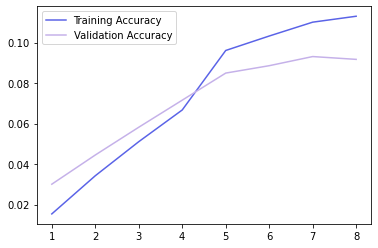

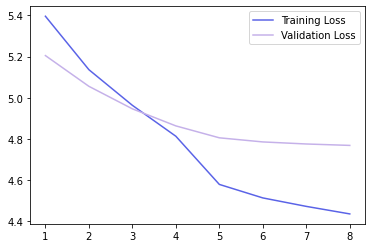

Accuracy on test set: 0.08321096003055573


tensor(0.0832, device='cuda:0')

In [68]:
#Création du MLP
mlp = MultiLayerPerceptron()
mlp.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Apprentissage du MLP sur le dataset noir/blanc
MLP['grey'] , history_MLP['grey'] =  train_model(mlp, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_grey)
MLP['grey'].to(device)

#Calcul de l'accuracy sur le test set
accu(MLP['grey'], dataloaders= dataloaders_grey)

## Réseau de Convolution 

On entraine ensuite notre réseau de convolution CNN : 

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 5.0735 Acc: 0.0365
val Loss: 4.6902 Acc: 0.0615

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 4.4519 Acc: 0.0911
val Loss: 4.3127 Acc: 0.1143

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 3.9488 Acc: 0.1620
val Loss: 3.5661 Acc: 0.2418

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 3.4709 Acc: 0.2338
val Loss: 3.2099 Acc: 0.3000

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 2.7575 Acc: 0.3560
val Loss: 2.7374 Acc: 0.3882

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 2.5746 Acc: 0.3944
val Loss: 2.6584 Acc: 0.4000

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 2.4548 Acc: 0.4162
val Loss: 2.5796 Acc: 0.4226

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 2.3570 Acc: 0.4338
val Loss: 2.5339 Acc: 0.4235

Training complete in 42m 29s
Best val Acc: 0.423484


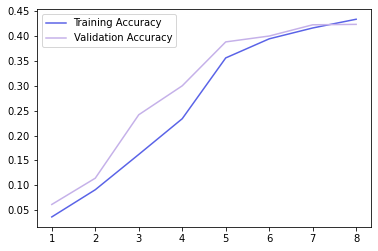

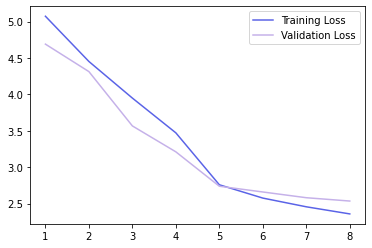

Accuracy on test set: 0.413281112909317


tensor(0.4133, device='cuda:0')

In [69]:
#Création du CNN
cnn = CNN()
cnn.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de notre CNN sur le dataset noir/blanc
Cnn['grey'] , history_Cnn['grey'] =  train_model(cnn, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_grey)
Cnn['grey'].to(device)

#Calcul de l'accuracy sur le test set
accu(Cnn['grey'], dataloaders= dataloaders_grey)

## ResNet18 

On entraine ensuite le réseau ResNet18 pré-entrainé pour lequel on aura freeze les premières couches :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 2.9070 Acc: 0.4121
val Loss: 1.6646 Acc: 0.6314

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 1.3965 Acc: 0.6854
val Loss: 1.3273 Acc: 0.6870

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 1.0717 Acc: 0.7500
val Loss: 1.2055 Acc: 0.7117

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.9030 Acc: 0.7849
val Loss: 1.1399 Acc: 0.7200

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.6969 Acc: 0.8498
val Loss: 1.0334 Acc: 0.7462

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.6786 Acc: 0.8564
val Loss: 1.0404 Acc: 0.7474

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.6634 Acc: 0.8605
val Loss: 1.0283 Acc: 0.7462

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.6595 Acc: 0.8640
val Loss: 1.0247 Acc: 0.7493

Training complete in 13m 2s
Best val Acc: 0.749349


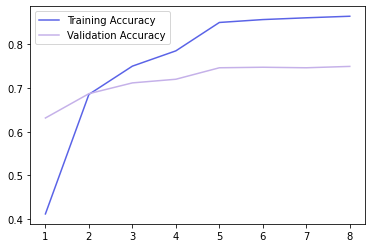

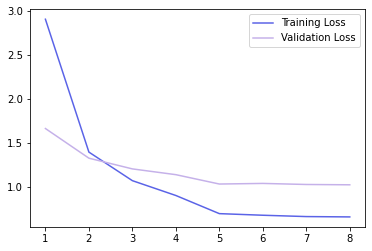

Accuracy on test set: 0.742861807346344


tensor(0.7429, device='cuda:0')

In [70]:
#Chargement de ResNet18 pré-entrainé
resNet18 = torchvision.models.resnet18(pretrained = True)
nb_features = resNet18.fc.in_features

#On freeze les premières couches
set_parameter_requires_grad(resNet18, True)

#Adaption du modèle à notre problème (on a 260 classes)
resNet18.fc = nn.Linear(nb_features, 260)
resNet18.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de ResNe18 sur le dataset noir/blanc
ResNet['grey'], history_ResNet['grey'] = train_model(resNet18, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_grey )
ResNet['grey'].to(device)

#Calcul de l'accuracy sur le test set
accu(ResNet['grey'],  dataloaders = dataloaders_grey)


## Densenet

On entraine ensuite le réseau DensNet pré-entrainé pour lequel on aura freeze les premières couches :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 2.3823 Acc: 0.5430
val Loss: 1.1008 Acc: 0.7700

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.8236 Acc: 0.8373
val Loss: 0.8074 Acc: 0.8162

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.5569 Acc: 0.8893
val Loss: 0.6972 Acc: 0.8360

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.4250 Acc: 0.9184
val Loss: 0.6438 Acc: 0.8470

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.3005 Acc: 0.9563
val Loss: 0.5988 Acc: 0.8612

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.2909 Acc: 0.9592
val Loss: 0.5967 Acc: 0.8640

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.2832 Acc: 0.9615
val Loss: 0.5924 Acc: 0.8624

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.2799 Acc: 0.9619
val Loss: 0.5867 Acc: 0.8650

Training complete in 44m 18s
Best val Acc: 0.865034


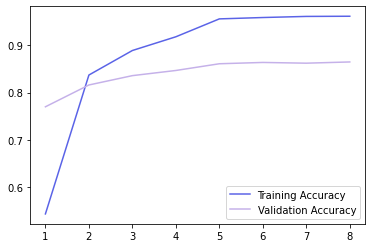

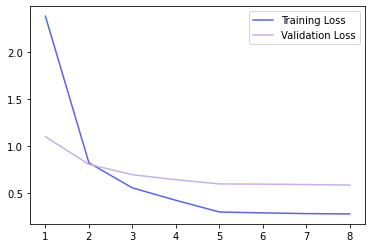

Accuracy on test set: 0.8588676452636719


tensor(0.8589, device='cuda:0')

In [36]:
#Chargement de densenet pré-entrainé
densenet = models.densenet161(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(densenet, True)

#On adapte le modèle à notre problèmes (260 classes)
densenet.classifier = nn.Linear(2208, 260)

densenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de DenseNet sur le dataset noir/blanc
DenseNet['grey'], history_DenseNet['grey'] = train_model(densenet, criterion, optimizer, lr_scheduler,  dataloaders = dataloaders_grey)
DenseNet['grey'].to(device)

#Calcul de l'accuracy sur le test set
accu(DenseNet['grey'],  dataloaders = dataloaders_grey)


## GoogleNet

On entraine ensuite le réseau GoogleNet pré-entrainé pour lequel on aura freeze les premières couches :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 3.8290 Acc: 0.3117
val Loss: 2.4734 Acc: 0.5694

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 2.1357 Acc: 0.6041
val Loss: 1.7411 Acc: 0.6568

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 1.6153 Acc: 0.6793
val Loss: 1.4760 Acc: 0.6946

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 1.3700 Acc: 0.7203
val Loss: 1.3259 Acc: 0.7057

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 1.2007 Acc: 0.7588
val Loss: 1.2743 Acc: 0.7236

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 1.1773 Acc: 0.7692
val Loss: 1.2609 Acc: 0.7268

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 1.1598 Acc: 0.7710
val Loss: 1.2543 Acc: 0.7276

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 1.1489 Acc: 0.7702
val Loss: 1.2484 Acc: 0.7301

Training complete in 14m 10s
Best val Acc: 0.730068


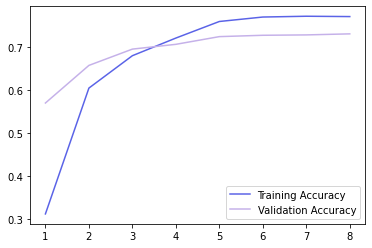

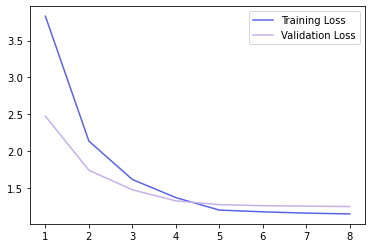

Accuracy on test set: 0.7236090898513794


tensor(0.7236, device='cuda:0')

In [71]:
#Chargement du modèle GoogleNet pré-entrainé
googlenet = models.googlenet(pretrained=True)

#On freeze les paramètres
set_parameter_requires_grad(googlenet, True)

#On adapte le modèle à notre problème (260 classes)
googlenet.fc = nn.Linear(1024, 260)
googlenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de GoogleNet sur le dataset noir/blanc
GoogleNet['grey'], history_GoogleNet['grey'] = train_model(googlenet, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_grey)
GoogleNet['grey'].to(device)

#Calcul de l'accuracy sur le test set
accu(GoogleNet['grey'], dataloaders = dataloaders_grey)

## Data Augmentation 

Afin d'avoir des modèles plus stables, nous avons essayé de les entrainer sur un dataset modifié aléatoirement avec plusieurs transformations :
   - *horizontal flip* = une chance sur deux de tourner l'image horizontalement
   - *random rotation* = tourne l'image aléatoirement d'un angle compris entre -20 et 20 degré
   
N.B: Les images sont normalisées et seules les images du train set subissent les transformations ci-dessus.

In [72]:
data_transforms_aug = {'train': transforms.Compose([
                    transforms.Resize([IMG_SIZE,IMG_SIZE]),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(degrees=(-20,20)),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std)
                  ]),
                  'val': transforms.Compose([
                    transforms.Resize([IMG_SIZE,IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std)

                  ]),
                  'test': transforms.Compose([
                    transforms.Resize([IMG_SIZE,IMG_SIZE]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std),
                  ]) 
                 }


images_dataset_aug = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms_aug[x])
                    for x in ['train', 'val', 'test']}
dataloaders_aug = {x: torch.utils.data.DataLoader(images_dataset_aug[x], batch_size=BATCH_SIZE,
                                                   shuffle=True,  num_workers=0)
                    for x in ['train', 'val', 'test']}


On affiche quelques images de notre dataset avec Data Augmentation :

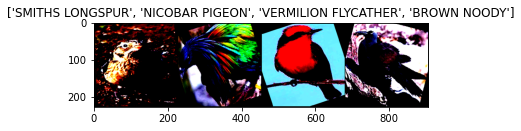

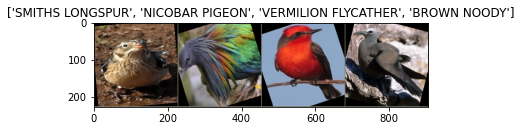

In [73]:
#Affichage d'image du dataset avec augmentation de données
images, classes = next(iter(dataloaders_aug['train']))


grid = torchvision.utils.make_grid(images[:4])

imshow(grid, title = [class_names[x] for x in classes[:4]])
imshow(grid, norm = True, title = [class_names[x] for x in classes[:4]])

# Réseaux de neurones avec Data Augmentation 

## Multi Layer Perceptron 

On commence par entrainer notre MLP sur le dataset avec data augmentation:

Epoch 1/8 LR:[0.001]
--------------------
train Loss: 5.3039 Acc: 0.0206
val Loss: 4.9190 Acc: 0.0459

Epoch 2/8 LR:[0.001]
--------------------
train Loss: 4.7556 Acc: 0.0554
val Loss: 4.5390 Acc: 0.0836

Epoch 3/8 LR:[0.001]
--------------------
train Loss: 4.4553 Acc: 0.0860
val Loss: 4.3658 Acc: 0.1042

Epoch 4/8 LR:[0.001]
--------------------
train Loss: 4.2527 Acc: 0.1124
val Loss: 4.2693 Acc: 0.1150

Epoch 5/8 LR:[0.0001]
--------------------
train Loss: 4.0035 Acc: 0.1505
val Loss: 4.1214 Acc: 0.1442

Epoch 6/8 LR:[0.0001]
--------------------
train Loss: 3.9306 Acc: 0.1607
val Loss: 4.1036 Acc: 0.1464

Epoch 7/8 LR:[0.0001]
--------------------
train Loss: 3.8944 Acc: 0.1648
val Loss: 4.0720 Acc: 0.1508

Epoch 8/8 LR:[0.0001]
--------------------
train Loss: 3.8638 Acc: 0.1725
val Loss: 4.0572 Acc: 0.1556

Training complete in 11m 39s
Best val Acc: 0.155637


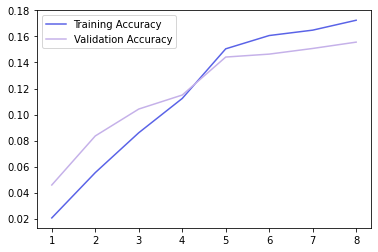

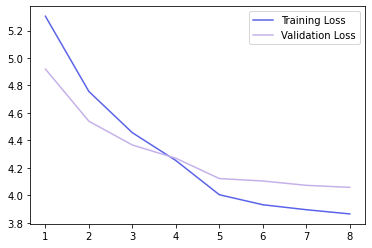

Accuracy on test set: 0.15043236315250397


tensor(0.1504, device='cuda:0')

In [74]:
#Définition du modèle
mlp = MultiLayerPerceptron()
mlp.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de MLP sur le dataset avec data augmentation
MLP['aug'] , history_MLP['aug'] =  train_model(mlp, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_aug)
MLP['aug'].to(device)

#Calcul sur le test set
accu(MLP['aug'], dataloaders= dataloaders_aug)

## Réseau de Convolution


On entraine ensuite notre réseau de convolution CNN :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 4.7070 Acc: 0.0655
val Loss: 3.8635 Acc: 0.1558

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 3.7866 Acc: 0.1742
val Loss: 3.2307 Acc: 0.2724

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 3.1450 Acc: 0.2812
val Loss: 2.7675 Acc: 0.3639

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 2.6656 Acc: 0.3688
val Loss: 2.1709 Acc: 0.4815

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 2.0197 Acc: 0.5039
val Loss: 1.7868 Acc: 0.5796

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 1.8614 Acc: 0.5401
val Loss: 1.7096 Acc: 0.5923

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 1.7629 Acc: 0.5537
val Loss: 1.6599 Acc: 0.6012

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 1.6860 Acc: 0.5733
val Loss: 1.5933 Acc: 0.6192

Training complete in 42m 49s
Best val Acc: 0.619246


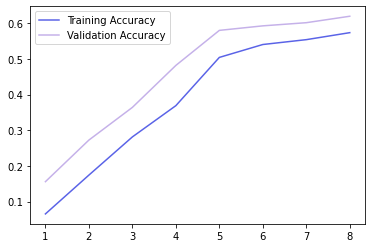

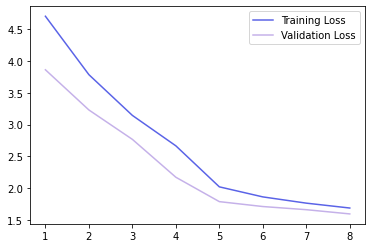

Accuracy on test set: 0.6149453520774841


tensor(0.6149, device='cuda:0')

In [75]:
#Définition du modèle
cnn = CNN()
cnn.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement du CNN sur le dataset avec data augmentation
Cnn['aug'] , history_Cnn['aug'] =  train_model(cnn, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_aug)
Cnn['aug'].to(device)

#Calcul de l'accuracy sur le test set
accu(Cnn['aug'], dataloaders= dataloaders_aug)

## ResNet18 

On entraine ensuite le réseau ResNet18 pré-entrainé pour lequel on aura freeze les premières couches sur le dataset avec data augmentation :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 2.3571 Acc: 0.5466
val Loss: 1.0858 Acc: 0.7587

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.8972 Acc: 0.8093
val Loss: 0.7936 Acc: 0.8171

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.6820 Acc: 0.8441
val Loss: 0.7023 Acc: 0.8284

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.5733 Acc: 0.8652
val Loss: 0.6375 Acc: 0.8423

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.4562 Acc: 0.9008
val Loss: 0.5773 Acc: 0.8607

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.4454 Acc: 0.9035
val Loss: 0.5766 Acc: 0.8579

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.4441 Acc: 0.9041
val Loss: 0.5654 Acc: 0.8635

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.4319 Acc: 0.9066
val Loss: 0.5760 Acc: 0.8617

Training complete in 13m 24s
Best val Acc: 0.863471


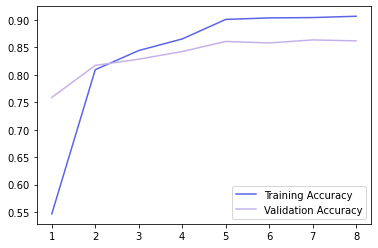

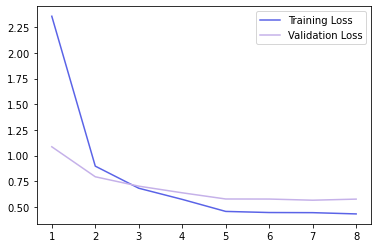

Accuracy on test set: 0.8637624382972717


tensor(0.8638, device='cuda:0')

In [76]:
#Chargement du modèle ResNet18 pré-entrainé 
resNet18 = torchvision.models.resnet18(pretrained = True)
nb_features = resNet18.fc.in_features

#On freeze les premières couches
set_parameter_requires_grad(resNet18, True)

#On adapte le modèle à notre problème (260 classes)
resNet18.fc = nn.Linear(nb_features, 260)
resNet18.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de ResNet18 avec le dataset (data augmentation)
ResNet['aug'], history_ResNet['aug'] = train_model(resNet18, criterion, optimizer, lr_scheduler, dataloaders = dataloaders_aug )
ResNet['aug'].to(device)

#Calcul de l'accuracy sur le test set
accu(ResNet['aug'],  dataloaders = dataloaders_aug)

## DenseNet

On entraine ensuite le réseau DenseNet pré-entrainé pour lequel on aura freeze les premières couches sur le dataset avec data augmentation :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 1.8462 Acc: 0.6802
val Loss: 0.6793 Acc: 0.8826

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.4991 Acc: 0.9100
val Loss: 0.4755 Acc: 0.9072

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.3452 Acc: 0.9346
val Loss: 0.4177 Acc: 0.9104

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.2652 Acc: 0.9523
val Loss: 0.3632 Acc: 0.9142

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.2018 Acc: 0.9678
val Loss: 0.3179 Acc: 0.9300

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.1916 Acc: 0.9701
val Loss: 0.3142 Acc: 0.9310

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.1910 Acc: 0.9706
val Loss: 0.3208 Acc: 0.9310

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.1877 Acc: 0.9703
val Loss: 0.3268 Acc: 0.9290

Training complete in 47m 1s
Best val Acc: 0.931040


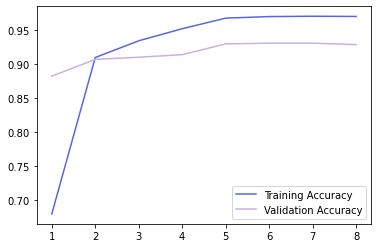

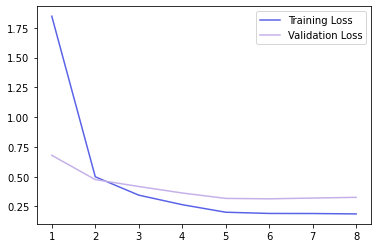

Accuracy on test set: 0.9345733523368835


tensor(0.9346, device='cuda:0')

In [39]:
#Chargement de DenseNet pré-entrainé
densenet = models.densenet161(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(densenet, True)

#On adapte le modèle à notre problème (260 classes)
densenet.classifier = nn.Linear(2208, 260)
densenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de DenseNet sur le dataset avec data augmentation
DenseNet['aug'], history_DenseNet['aug'] = train_model(densenet, criterion, optimizer, lr_scheduler,  dataloaders = dataloaders_aug)
DenseNet['aug'].to(device)

#Calcul de l'accuracy sur le test set
accu(DenseNet['aug'],  dataloaders = dataloaders_aug)

## GoogleNet

On entraine enfin le réseau GoogleNet pré-entrainé pour lequel on aura freeze les premières couches sur le dataset avec data augmentation :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 3.5558 Acc: 0.3911
val Loss: 2.0330 Acc: 0.6774

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 1.7512 Acc: 0.6953
val Loss: 1.2970 Acc: 0.7716

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 1.2744 Acc: 0.7595
val Loss: 1.0315 Acc: 0.8077

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 1.0709 Acc: 0.7868
val Loss: 0.9015 Acc: 0.8181

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.9528 Acc: 0.8140
val Loss: 0.8562 Acc: 0.8331

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.9281 Acc: 0.8209
val Loss: 0.8461 Acc: 0.8339

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.9167 Acc: 0.8223
val Loss: 0.8454 Acc: 0.8385

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.9059 Acc: 0.8214
val Loss: 0.8429 Acc: 0.8341

Training complete in 14m 28s
Best val Acc: 0.838458


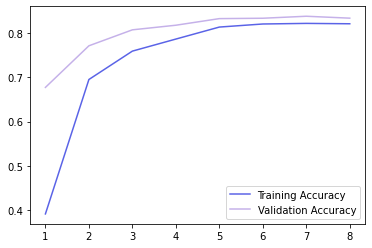

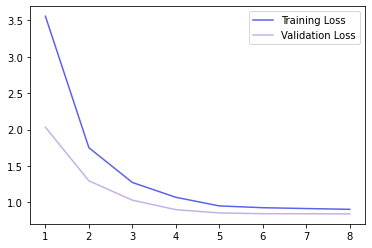

Accuracy on test set: 0.824604332447052


tensor(0.8246, device='cuda:0')

In [77]:
#Chargement du modèle GoogleNet pré-entrainé
googlenet = models.googlenet(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(googlenet, True)

#On adapte le modèle à notre problème (260 classes)
googlenet.fc = nn.Linear(1024, 260)
googlenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de GoogleNet sur le dataset avec data augmentation
GoogleNet['aug'], history_GoogleNet['aug'] = train_model(googlenet, criterion, optimizer, lr_scheduler,  dataloaders = dataloaders_aug)
GoogleNet['aug'].to(device)

#Calcul de l'accuracy sur le test set
accu(GoogleNet['aug'], dataloaders = dataloaders_aug)

# Réseaux de neurones sans normalisation

Enfin nous avons décidé d'entrainer nos modèles sur notre dataset non normalisé afin de comparer la convergence de nos modèles :

## Multi Layer Perceptron non normalisé

On entraine tout d'abord notre MLP sur le dataset non normalisé :

Epoch 1/8 LR:[0.001]
--------------------
train Loss: 5.5567 Acc: 0.0053
val Loss: 5.5395 Acc: 0.0080

Epoch 2/8 LR:[0.001]
--------------------
train Loss: 5.5163 Acc: 0.0077
val Loss: 5.4493 Acc: 0.0123

Epoch 3/8 LR:[0.001]
--------------------
train Loss: 5.3933 Acc: 0.0120
val Loss: 5.2732 Acc: 0.0222

Epoch 4/8 LR:[0.001]
--------------------
train Loss: 5.2012 Acc: 0.0198
val Loss: 5.0163 Acc: 0.0301

Epoch 5/8 LR:[0.0001]
--------------------
train Loss: 5.0211 Acc: 0.0292
val Loss: 4.9421 Acc: 0.0400

Epoch 6/8 LR:[0.0001]
--------------------
train Loss: 4.9813 Acc: 0.0325
val Loss: 4.9134 Acc: 0.0398

Epoch 7/8 LR:[0.0001]
--------------------
train Loss: 4.9599 Acc: 0.0320
val Loss: 4.8827 Acc: 0.0439

Epoch 8/8 LR:[0.0001]
--------------------
train Loss: 4.9317 Acc: 0.0328
val Loss: 4.8611 Acc: 0.0455

Training complete in 9m 37s
Best val Acc: 0.045510


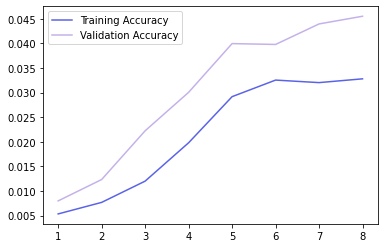

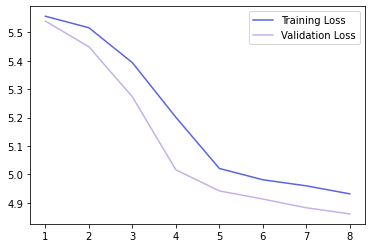

Accuracy on test set: 0.04062652960419655


tensor(0.0406, device='cuda:0')

In [78]:
#Définition du modèle
mlp = MultiLayerPerceptron()
mlp.to(device)

#Définition de nos criètes
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entraintement de notre MLP sur le dataset non normalisé
MLP['no_norm'] , history_MLP['no_norm'] =  train_model(mlp, criterion, optimizer, lr_scheduler, dataloaders = dataloaders)
MLP['no_norm'].to(device)

#Calcul de l'accuracy sur le test set
accu(MLP['no_norm'], dataloaders= dataloaders)

## Réseau de Convolution non normalisé

On entraine ensuite notre réseau de convolution CNN sur le dataset non normalisé : 

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 4.7112 Acc: 0.0652
val Loss: 4.1081 Acc: 0.1404

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 3.7208 Acc: 0.1871
val Loss: 3.4432 Acc: 0.2460

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 2.9820 Acc: 0.3159
val Loss: 2.5502 Acc: 0.4112

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 2.3825 Acc: 0.4312
val Loss: 2.1505 Acc: 0.4989

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 1.6478 Acc: 0.5828
val Loss: 1.7225 Acc: 0.5817

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 1.4751 Acc: 0.6244
val Loss: 1.6687 Acc: 0.5968

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 1.3856 Acc: 0.6406
val Loss: 1.6361 Acc: 0.6027

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 1.3005 Acc: 0.6602
val Loss: 1.5862 Acc: 0.6144

Training complete in 42m 26s
Best val Acc: 0.614382


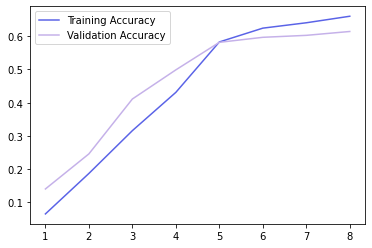

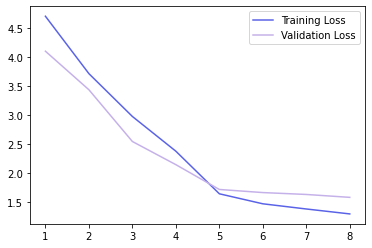

Accuracy on test set: 0.6193506121635437


tensor(0.6194, device='cuda:0')

In [18]:
#Définition de notre CNN
cnn = CNN()
cnn.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entraiment de notre CNN sur le dataset non normalisé
Cnn['no_norm'] , history_Cnn['no_norm'] =  train_model(cnn, criterion, optimizer, lr_scheduler, dataloaders = dataloaders)
Cnn['no_norm'].to(device)

#Calcul de l'accuracy sur le test set
accu(Cnn['no_norm'], dataloaders= dataloaders)

## ResNet18 non normalisé

On entraine ensuite le réseau ResNet18 pré-entrainé pour lequel on aura freeze les premières couches sur le dataset non normalisé :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 2.0637 Acc: 0.6080
val Loss: 0.8428 Acc: 0.8218

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.6783 Acc: 0.8606
val Loss: 0.6252 Acc: 0.8543

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.4800 Acc: 0.8990
val Loss: 0.5478 Acc: 0.8666

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.3846 Acc: 0.9194
val Loss: 0.5116 Acc: 0.8742

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.2831 Acc: 0.9505
val Loss: 0.4646 Acc: 0.8890

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.2731 Acc: 0.9518
val Loss: 0.4602 Acc: 0.8899

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.2697 Acc: 0.9543
val Loss: 0.4643 Acc: 0.8890

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.2660 Acc: 0.9552
val Loss: 0.4550 Acc: 0.8883

Training complete in 13m 2s
Best val Acc: 0.889873


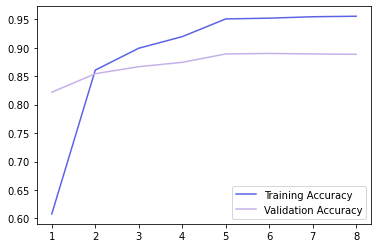

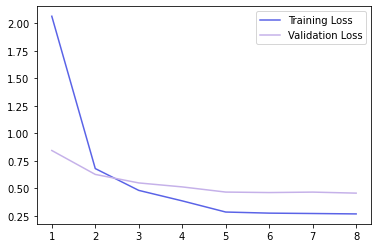

Accuracy on test set: 0.8929678201675415


tensor(0.8930, device='cuda:0')

In [19]:
#Chargement de ResNet18 pré-entrainé 
resNet18 = torchvision.models.resnet18(pretrained = True)
nb_features = resNet18.fc.in_features

#On freeze les premières couches
set_parameter_requires_grad(resNet18, True)

#On adapte le modèle à notre problème (260 classes)
resNet18.fc = nn.Linear(nb_features, 260)
resNet18.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resNet18.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de ResNet18 sur le dataset non normalisé
ResNet['no_norm'], history_ResNet['no_norm'] = train_model(resNet18, criterion, optimizer, lr_scheduler, dataloaders = dataloaders)
ResNet['no_norm'].to(device)

#Calcul de l'accuracy sur le test set
accu(ResNet['no_norm'],  dataloaders = dataloaders)

## DenseNet non normalisé

On entraine ensuite le réseau DenseNet pré-entrainé pour lequel on aura freeze les premières couches sur le dataset non normalisé:

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 1.6076 Acc: 0.7260
val Loss: 0.5120 Acc: 0.9065

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 0.3650 Acc: 0.9407
val Loss: 0.3564 Acc: 0.9274

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 0.2302 Acc: 0.9640
val Loss: 0.3016 Acc: 0.9376

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.1682 Acc: 0.9756
val Loss: 0.2774 Acc: 0.9371

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.1221 Acc: 0.9876
val Loss: 0.2569 Acc: 0.9458

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.1164 Acc: 0.9895
val Loss: 0.2550 Acc: 0.9460

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.1144 Acc: 0.9894
val Loss: 0.2561 Acc: 0.9448

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.1120 Acc: 0.9893
val Loss: 0.2545 Acc: 0.9451

Training complete in 44m 35s
Best val Acc: 0.945979


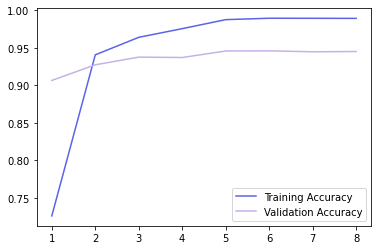

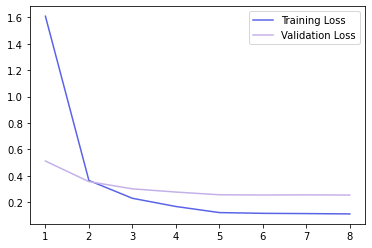

Accuracy on test set: 0.9455049633979797


tensor(0.9455, device='cuda:0')

In [40]:
#Chargement de DenseNet pré-entrainé 
densenet = models.densenet161(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(densenet, True)

#Adaption du modèle à notre problème(260 classes)
densenet.classifier = nn.Linear(2208, 260)
densenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de DenseNet sur notre dataset non normalisé
DenseNet['no_norm'], history_DenseNet['no_norm'] = train_model(densenet, criterion, optimizer, lr_scheduler,  dataloaders = dataloaders)
DenseNet['no_norm'].to(device)

#Calcul de l'accuracy sur le test set
accu(DenseNet['no_norm'],  dataloaders = dataloaders)

## GoogleNet non normalisé

On entraine ensuite le réseau GoogleNet pré-entrainé pour lequel on aura freeze les premières couches sur le dataset non normalisé :

Epoch 1/8 LR:[0.01]
--------------------
train Loss: 3.2869 Acc: 0.4476
val Loss: 1.7326 Acc: 0.7422

Epoch 2/8 LR:[0.01]
--------------------
train Loss: 1.4539 Acc: 0.7622
val Loss: 1.1121 Acc: 0.8035

Epoch 3/8 LR:[0.01]
--------------------
train Loss: 1.0157 Acc: 0.8177
val Loss: 0.8947 Acc: 0.8263

Epoch 4/8 LR:[0.01]
--------------------
train Loss: 0.8268 Acc: 0.8448
val Loss: 0.7754 Acc: 0.8464

Epoch 5/8 LR:[0.001]
--------------------
train Loss: 0.7144 Acc: 0.8726
val Loss: 0.7399 Acc: 0.8588

Epoch 6/8 LR:[0.001]
--------------------
train Loss: 0.6985 Acc: 0.8764
val Loss: 0.7446 Acc: 0.8583

Epoch 7/8 LR:[0.001]
--------------------
train Loss: 0.6875 Acc: 0.8773
val Loss: 0.7376 Acc: 0.8600

Epoch 8/8 LR:[0.001]
--------------------
train Loss: 0.6795 Acc: 0.8804
val Loss: 0.7376 Acc: 0.8586

Training complete in 13m 48s
Best val Acc: 0.859997


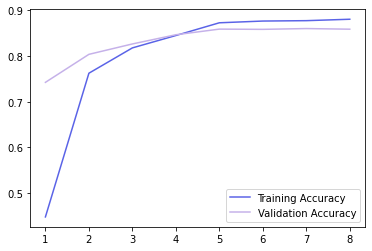

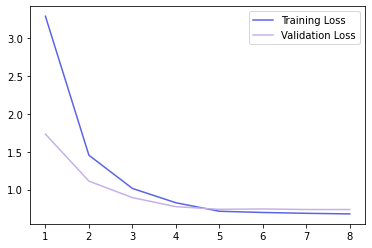

Accuracy on test set: 0.8518518209457397


tensor(0.8519, device='cuda:0')

In [20]:
#Chargement de GoogleNet pré-entrainé
googlenet = models.googlenet(pretrained=True)

#On freeze les premières couches
set_parameter_requires_grad(googlenet, True)

#On adapte le modèle à notre problème
googlenet.fc = nn.Linear(1024, 260)
googlenet.to(device)

#Définition de nos critères
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(googlenet.parameters(), lr=0.01, momentum = 0.9)
lr_scheduler = StepLR(optimizer, step_size = 4, gamma = 0.1)

#Entrainement de GoogleNet sur le dataset non normalisé
GoogleNet['no_norm'], history_GoogleNet['no_norm'] = train_model(googlenet, criterion, optimizer, lr_scheduler,  dataloaders = dataloaders)
GoogleNet['no_norm'].to(device)

#Calcul de l'accuracy sur le test set
accu(GoogleNet['no_norm'], dataloaders = dataloaders)

# SVM Resize

Ne pouvant entrer nos images directement dans un SVM à cause de leur nombre et de leur taille, nous nous sommes tout de même questionné sur l'efficacité d'un SVM sur un dataset où les images ont été resize en 32x32 :

In [120]:
data_transforms_size = {'train': transforms.Compose([
                    transforms.Resize([32,32]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std)
                  ]),
                  'val': transforms.Compose([
                    transforms.Resize([32,32]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std)

                  ]),
                  'test': transforms.Compose([
                    transforms.Resize([32,32]),
                    transforms.ToTensor(),
                    transforms.Normalize(data_mean,data_std),
                  ]) 
                 }


images_dataset_size = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms_size[x])
                    for x in ['train', 'val', 'test']}
dataloaders_size = {x: torch.utils.data.DataLoader(images_dataset_size[x], batch_size=BATCH_SIZE,
                                                   shuffle=True,  num_workers=0)
                    for x in ['train', 'val', 'test']}



On affiche quelques images de notre dataset resize afin d'en avoir un aperçu :

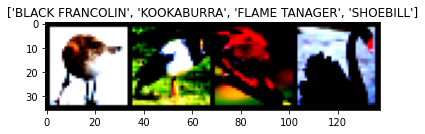

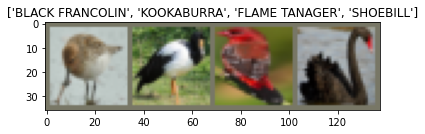

In [125]:
#Affichage d'image du dataset resize
images, classes = next(iter(dataloaders_size['train']))


grid = torchvision.utils.make_grid(images[20:24])

imshow(grid, title = [class_names[x] for x in classes[:4]])
imshow(grid, norm = True, title = [class_names[x] for x in classes[:4]])

On récupère ensuite dans un numpy nos images sous forme de vecteur de size 3x32x32 :

In [25]:
X_size = {'train': [],
     'val': [],
     'test':[]}
y_size = {'train':[],
     'val': [],
     'test': []}


for phase in ['train', 'val', 'test']:
    #tqdm
    for (inputs, labels) in dataloaders_size[phase]:
        inputs = inputs.to(device)


        for output, label in zip(inputs, labels):
            X_size [phase].append(output.view(3*32*32).cpu().numpy())
            y_size[phase].append(label.cpu().numpy())

    X_size [phase] = np.array(X_size[phase])
    y_size[phase] = np.array(y_size[phase])
    
print('Downloading Done!')


On effectue notre SVM sur les données resize :

In [28]:
size_svm = SVC(random_state = 1223)

accu_size = accuracy(size_svm,X_size['train'],y_size['train'],X_size['test'],y_size['test'])

print("Accuracy sur un SVM avec des images resize 32 x 32 : {}".format(accu_size))


Prediction complete in 31m 48s
Accuracy sur un SVM avec des images resize 32 x 32 : 0.20476423560124002


# Comparatif de nos modèles

Nous avons tout d'abord décidé de comparer les modèles en fonction du dataset sur lequel ils ont été entrainés:

## Multi Layer Perceptron

history_MLP['norm']['accuracy'] =  [0.0565, 0.1131, 0.1511, 0.1758, 0.2077, 0.215, 0.2196, 0.2244]
history_MLP['grey']['accuracy'] =  [0.0271, 0.0492, 0.0618, 0.0636, 0.0806, 0.0858, 0.086, 0.0889]
history_MLP['aug']['accuracy'] =  [0.0412, 0.0724, 0.0964, 0.1294, 0.1426, 0.1475, 0.1483, 0.1506]
history_MLP['no_norm']['accuracy'] =  [0.0089, 0.0156, 0.02, 0.0252, 0.0358, 0.0396, 0.0387, 0.041]


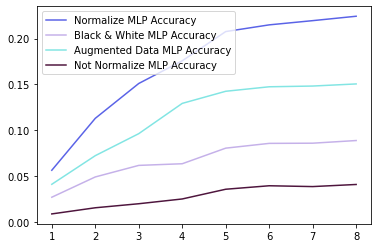

In [59]:
#Historique obtenu à l'aide des exécution précédentes afin d'éviter d'avoir à tout réapprendre
'''for phase in ['norm', 'grey', 'aug', 'no_norm']:
    history_MLP[phase]={'accuracy':[]}

history_MLP['norm']['accuracy'] = [0.0565, 0.1131, 0.1511, 0.1758, 0.2077, 0.2150, 0.2196, 0.2244]
history_MLP['grey']['accuracy'] = [0.0271, 0.0492, 0.0618, 0.0636, 0.0806, 0.0858, 0.0860, 0.0889]
history_MLP['aug']['accuracy'] = [0.0412, 0.0724, 0.0964, 0.1294, 0.1426, 0.1475, 0.1483, 0.1506]
history_MLP['no_norm']['accuracy'] = [0.0089, 0.0156, 0.0200, 0.0252, 0.0358, 0.0396, 0.0387, 0.0410]

print("history_MLP['norm']['accuracy'] = ", history_MLP['norm']['accuracy'])
print("history_MLP['grey']['accuracy'] = ", history_MLP['grey']['accuracy'])
print("history_MLP['aug']['accuracy'] = ", history_MLP['aug']['accuracy'])
print("history_MLP['no_norm']['accuracy'] = ", history_MLP['no_norm']['accuracy'])'''

n = len(history_MLP['norm']['accuracy'])



plt.plot(np.arange(1,n+1), history_MLP['norm']['accuracy'], color ='#5A63E7',label = 'Normalize MLP Accuracy')
plt.plot(np.arange(1,n+1), history_MLP['grey']['accuracy'], color ='#C5B1E9',label = 'Black & White MLP Accuracy')
plt.plot(np.arange(1,n+1), history_MLP['aug']['accuracy'], color ='#82E5E3',label = 'Augmented Data MLP Accuracy')
plt.plot(np.arange(1,n+1), history_MLP['no_norm']['accuracy'], color ='#4E153D', label = 'Not Normalize MLP Accuracy')
    
plt.legend()
plt.show()

## Réseau de Convolution

history_Cnn['norm']['accuracy'] =  [0.1581, 0.2944, 0.4035, 0.4867, 0.5843, 0.6015, 0.6128, 0.6128]
history_Cnn['grey']['accuracy'] =  [0.0874, 0.1219, 0.2373, 0.2969, 0.3887, 0.4013, 0.4202, 0.4325]
history_Cnn['aug']['accuracy'] =  [0.1525, 0.2689, 0.3926, 0.4676, 0.5685, 0.5895, 0.5954, 0.608]
history_Cnn['no_norm']['accuracy'] =  [0.152, 0.2593, 0.3769, 0.4766, 0.5776, 0.5913, 0.6017, 0.6054]


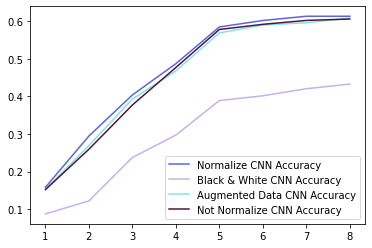

In [60]:
#Historique obtenu à l'aide des exécution précédentes afin d'éviter d'avoir à tout réapprendre
'''for phase in ['norm', 'grey', 'aug', 'no_norm']:
    history_Cnn[phase]={'accuracy':[]}

history_Cnn['norm']['accuracy'] = [0.1581, 0.2944, 0.4035, 0.4867, 0.5843, 0.6015, 0.6128, 0.6128]
history_Cnn['grey']['accuracy'] = [0.0874, 0.1219, 0.2373, 0.2969, 0.3887, 0.4013, 0.4202, 0.4325]
history_Cnn['aug']['accuracy'] = [0.1525, 0.2689, 0.3926, 0.4676, 0.5685, 0.5895, 0.5954, 0.6080]
history_Cnn['no_norm']['accuracy'] = [0.1520, 0.2593, 0.3769, 0.4766, 0.5776, 0.5913, 0.6017, 0.6054]

print("history_Cnn['norm']['accuracy'] = ", history_Cnn['norm']['accuracy'])
print("history_Cnn['grey']['accuracy'] = ", history_Cnn['grey']['accuracy'])
print("history_Cnn['aug']['accuracy'] = ", history_Cnn['aug']['accuracy'])
print("history_Cnn['no_norm']['accuracy'] = ", history_Cnn['no_norm']['accuracy'])'''

n = len(history_Cnn['norm']['accuracy'])

plt.plot(np.arange(1,n+1), history_Cnn['norm']['accuracy'], color ='#5A63E7',label = 'Normalize CNN Accuracy')
plt.plot(np.arange(1,n+1), history_Cnn['grey']['accuracy'], color ='#C5B1E9',label = 'Black & White CNN Accuracy')
plt.plot(np.arange(1,n+1), history_Cnn['aug']['accuracy'], color ='#82E5E3',label = 'Augmented Data CNN Accuracy')
plt.plot(np.arange(1,n+1), history_Cnn['no_norm']['accuracy'], color ='#4E153D', label = 'Not Normalize CNN Accuracy')
    
plt.legend()
plt.show()

## ResNet18

history_ResNet['norm']['accuracy'] =  [0.8233, 0.8574, 0.8701, 0.8819, 0.8904, 0.8887, 0.8928, 0.8921]
history_ResNet['grey']['accuracy'] =  [0.6184, 0.6807, 0.7101, 0.7223, 0.746, 0.7448, 0.7485, 0.7497]
history_ResNet['aug']['accuracy'] =  [0.7636, 0.822, 0.8334, 0.8431, 0.859, 0.8607, 0.8614, 0.8631]
history_ResNet['no_norm']['accuracy'] =  [0.8105, 0.8598, 0.8675, 0.8749, 0.8909, 0.8907, 0.8927, 0.8895]


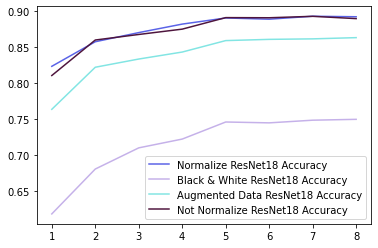

In [61]:
#Historique obtenu à l'aide des exécution précédentes afin d'éviter d'avoir à tout réapprendre
'''for phase in ['norm', 'grey', 'aug', 'no_norm']:
    history_ResNet[phase]={'accuracy':[]}

history_ResNet['norm']['accuracy'] = [0.8233, 0.8574, 0.8701, 0.8819, 0.8904, 0.8887, 0.8928, 0.8921]
history_ResNet['grey']['accuracy'] = [0.6184, 0.6807, 0.7101, 0.7223, 0.7460, 0.7448, 0.7485, 0.7497]
history_ResNet['aug']['accuracy'] = [0.7636, 0.8220, 0.8334, 0.8431, 0.8590, 0.8607, 0.8614, 0.8631]
history_ResNet['no_norm']['accuracy'] = [0.8105, 0.8598, 0.8675, 0.8749, 0.8909, 0.8907, 0.8927, 0.8895]

print("history_ResNet['norm']['accuracy'] = ", history_ResNet['norm']['accuracy'])
print("history_ResNet['grey']['accuracy'] = ", history_ResNet['grey']['accuracy'])
print("history_ResNet['aug']['accuracy'] = ", history_ResNet['aug']['accuracy'])
print("history_ResNet['no_norm']['accuracy'] = ", history_ResNet['no_norm']['accuracy'])'''

n = len(history_ResNet['norm']['accuracy'])

plt.plot(np.arange(1,n+1), history_ResNet['norm']['accuracy'], color ='#5A63E7', label = 'Normalize ResNet18 Accuracy')
plt.plot(np.arange(1,n+1), history_ResNet['grey']['accuracy'], color ='#C5B1E9', label = 'Black & White ResNet18 Accuracy')
plt.plot(np.arange(1,n+1), history_ResNet['aug']['accuracy'], color ='#82E5E3', label = 'Augmented Data ResNet18 Accuracy')
plt.plot(np.arange(1,n+1), history_ResNet['no_norm']['accuracy'], color ='#4E153D', label = 'Not Normalize ResNet18 Accuracy')
    
plt.legend()
plt.show()

## DenseNet

history_DenseNet['norm']['accuracy'] =  [0.9071, 0.9239, 0.9352, 0.938, 0.9451, 0.9462, 0.9458, 0.946]
history_DenseNet['grey']['accuracy'] =  [0.77, 0.8162, 0.836, 0.847, 0.8612, 0.864, 0.8624, 0.865]
history_DenseNet['aug']['accuracy'] =  [0.8826, 0.9072, 0.9104, 0.9142, 0.93, 0.931, 0.931, 0.929]
history_DenseNet['no_norm']['accuracy'] =  [0.9065, 0.9274, 0.9376, 0.9371, 0.9458, 0.946, 0.9448, 0.9451]


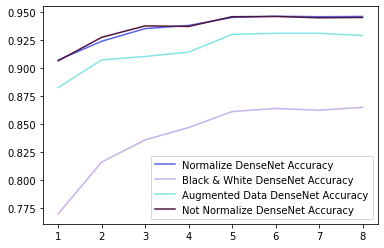

In [62]:
#Historique obtenu à l'aide des exécution précédentes afin d'éviter d'avoir à tout réapprendre
'''for phase in ['norm', 'grey', 'aug', 'no_norm']:
    history_DenseNet[phase]={'accuracy':[]}

history_DenseNet['norm']['accuracy'] = [0.9071, 0.9239, 0.9352, 0.9380, 0.9451, 0.9462, 0.9458, 0.9460]
history_DenseNet['grey']['accuracy'] = [0.7700, 0.8162, 0.8360, 0.8470, 0.8612, 0.8640, 0.8624, 0.8650]
history_DenseNet['aug']['accuracy'] =  [0.8826, 0.9072, 0.9104, 0.9142, 0.9300, 0.9310, 0.9310, 0.9290]
history_DenseNet['no_norm']['accuracy'] = [0.9065, 0.9274, 0.9376, 0.9371, 0.9458, 0.9460, 0.9448, 0.9451]

print("history_DenseNet['norm']['accuracy'] = ", history_DenseNet['norm']['accuracy'])
print("history_DenseNet['grey']['accuracy'] = ", history_DenseNet['grey']['accuracy'])
print("history_DenseNet['aug']['accuracy'] = ", history_DenseNet['aug']['accuracy'])
print("history_DenseNet['no_norm']['accuracy'] = ", history_DenseNet['no_norm']['accuracy'])'''

n = len(history_DenseNet['norm']['accuracy'])

plt.plot(np.arange(1,n+1), history_DenseNet['norm']['accuracy'], color ='#5A63E7', label = 'Normalize DenseNet Accuracy')
plt.plot(np.arange(1,n+1), history_DenseNet['grey']['accuracy'], color ='#C5B1E9', label = 'Black & White DenseNet Accuracy')
plt.plot(np.arange(1,n+1), history_DenseNet['aug']['accuracy'], color ='#82E5E3', label = 'Augmented Data DenseNet Accuracy')
plt.plot(np.arange(1,n+1), history_DenseNet['no_norm']['accuracy'], color ='#4E153D', label = 'Not Normalize DenseNet Accuracy')
    
plt.legend()
plt.show()

## GoogleNet

history_GoogleNet['norm']['accuracy'] =  [0.7433, 0.806, 0.8353, 0.8459, 0.8563, 0.8609, 0.861, 0.8609]
history_GoogleNet['grey']['accuracy'] =  [0.5545, 0.6573, 0.6927, 0.7101, 0.7216, 0.7271, 0.7304, 0.729]
history_GoogleNet['aug']['accuracy'] =  [0.6846, 0.7784, 0.799, 0.8127, 0.8369, 0.8352, 0.8353, 0.8362]
history_GoogleNet['no_norm']['accuracy'] =  [0.7384, 0.8046, 0.8268, 0.8374, 0.8569, 0.8574, 0.8572, 0.8586]


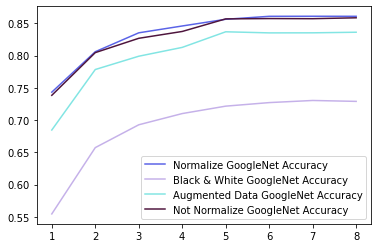

In [63]:
#Historique obtenu à l'aide des exécution précédentes afin d'éviter d'avoir à tout réapprendre
'''for phase in ['norm', 'grey', 'aug', 'no_norm']:
    history_GoogleNet[phase]={'accuracy':[]}

history_GoogleNet['norm']['accuracy'] = [0.7433, 0.8060, 0.8353, 0.8459, 0.8563, 0.8609, 0.8610, 0.8609]
history_GoogleNet['grey']['accuracy'] = [0.5545, 0.6573, 0.6927, 0.7101, 0.7216, 0.7271, 0.7304, 0.7290]
history_GoogleNet['aug']['accuracy'] = [0.6846, 0.7784, 0.7990, 0.8127, 0.8369, 0.8352, 0.8353, 0.8362]
history_GoogleNet['no_norm']['accuracy'] = [0.7384, 0.8046, 0.8268, 0.8374, 0.8569, 0.8574, 0.8572, 0.8586]

print("history_GoogleNet['norm']['accuracy'] = ", history_GoogleNet['norm']['accuracy'])
print("history_GoogleNet['grey']['accuracy'] = ", history_GoogleNet['grey']['accuracy'])
print("history_GoogleNet['aug']['accuracy'] = ", history_GoogleNet['aug']['accuracy'])
print("history_GoogleNet['no_norm']['accuracy'] = ", history_GoogleNet['no_norm']['accuracy'])'''


n = len(history_GoogleNet['norm']['accuracy'])

plt.plot(np.arange(1,n+1), history_GoogleNet['norm']['accuracy'], color ='#5A63E7', label = 'Normalize GoogleNet Accuracy')
plt.plot(np.arange(1,n+1), history_GoogleNet['grey']['accuracy'], color ='#C5B1E9', label = 'Black & White GoogleNet Accuracy')
plt.plot(np.arange(1,n+1), history_GoogleNet['aug']['accuracy'], color ='#82E5E3', label = 'Augmented Data GoogleNet Accuracy')
plt.plot(np.arange(1,n+1), history_GoogleNet['no_norm']['accuracy'], color ='#4E153D', label = 'Not Normalize GoogleNet Accuracy')
    
plt.legend()
plt.show()

## Graphique final 

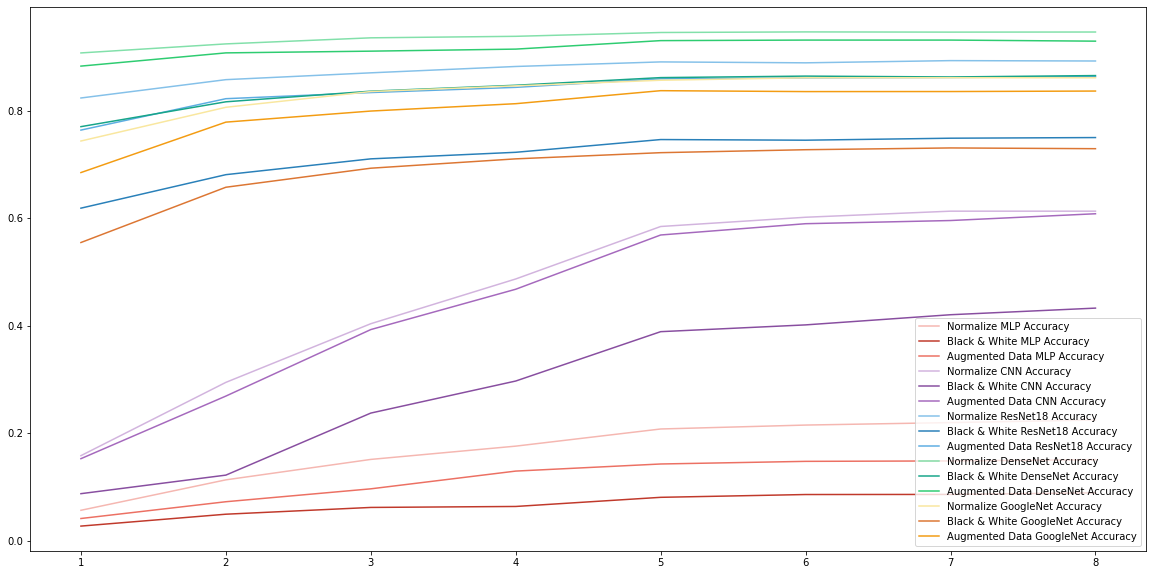

In [65]:
plt.figure(figsize=(20,10))

plt.plot(np.arange(1,n+1), history_MLP['norm']['accuracy'], color ='#F5B7B1',label = 'Normalize MLP Accuracy')
plt.plot(np.arange(1,n+1), history_MLP['grey']['accuracy'], color ='#C0392B',label = 'Black & White MLP Accuracy')
plt.plot(np.arange(1,n+1), history_MLP['aug']['accuracy'], color ='#EC7063',label = 'Augmented Data MLP Accuracy')

plt.plot(np.arange(1,n+1), history_Cnn['norm']['accuracy'], color ='#D2B4DE',label = 'Normalize CNN Accuracy')
plt.plot(np.arange(1,n+1), history_Cnn['grey']['accuracy'], color ='#884EA0',label = 'Black & White CNN Accuracy')
plt.plot(np.arange(1,n+1), history_Cnn['aug']['accuracy'], color ='#A569BD',label = 'Augmented Data CNN Accuracy')

plt.plot(np.arange(1,n+1), history_ResNet['norm']['accuracy'], color ='#85C1E9', label = 'Normalize ResNet18 Accuracy')
plt.plot(np.arange(1,n+1), history_ResNet['grey']['accuracy'], color ='#2980B9', label = 'Black & White ResNet18 Accuracy')
plt.plot(np.arange(1,n+1), history_ResNet['aug']['accuracy'], color ='#5DADE2', label = 'Augmented Data ResNet18 Accuracy')

plt.plot(np.arange(1,n+1), history_DenseNet['norm']['accuracy'], color ='#82E0AA', label = 'Normalize DenseNet Accuracy')
plt.plot(np.arange(1,n+1), history_DenseNet['grey']['accuracy'], color ='#17A589', label = 'Black & White DenseNet Accuracy')
plt.plot(np.arange(1,n+1), history_DenseNet['aug']['accuracy'], color ='#2ECC71', label = 'Augmented Data DenseNet Accuracy')

plt.plot(np.arange(1,n+1), history_GoogleNet['norm']['accuracy'], color ='#F9E79F', label = 'Normalize GoogleNet Accuracy')
plt.plot(np.arange(1,n+1), history_GoogleNet['grey']['accuracy'], color ='#DC7633', label = 'Black & White GoogleNet Accuracy')
plt.plot(np.arange(1,n+1), history_GoogleNet['aug']['accuracy'], color ='#F39C12', label = 'Augmented Data GoogleNet Accuracy')

plt.legend()
plt.show()

On définit une fonction *get_class()* qui permet de retourner une image de la classe voulue :
   - **index** : numéro de classe recherchée
   
La fonction renvoie :
   - **image** : une image de la classe correspondante
   - **None** si aucune image n'a été trouvée (notre dataset étant complet cela n'arrivera pas pour un nombre inférieur  à 260)

In [183]:
def get_class(index):
    for images, classes in iter(dataloaders['val']):
        for image, classe in zip(images, classes):
            if classe.numpy() == index:
                return image
    return None

Nous avons choisi comme modèle final, le modèle DenseNet entrainé avec Data Augmentation.  
Nous allons donc afficher la matrice de confusion de ce modèle :

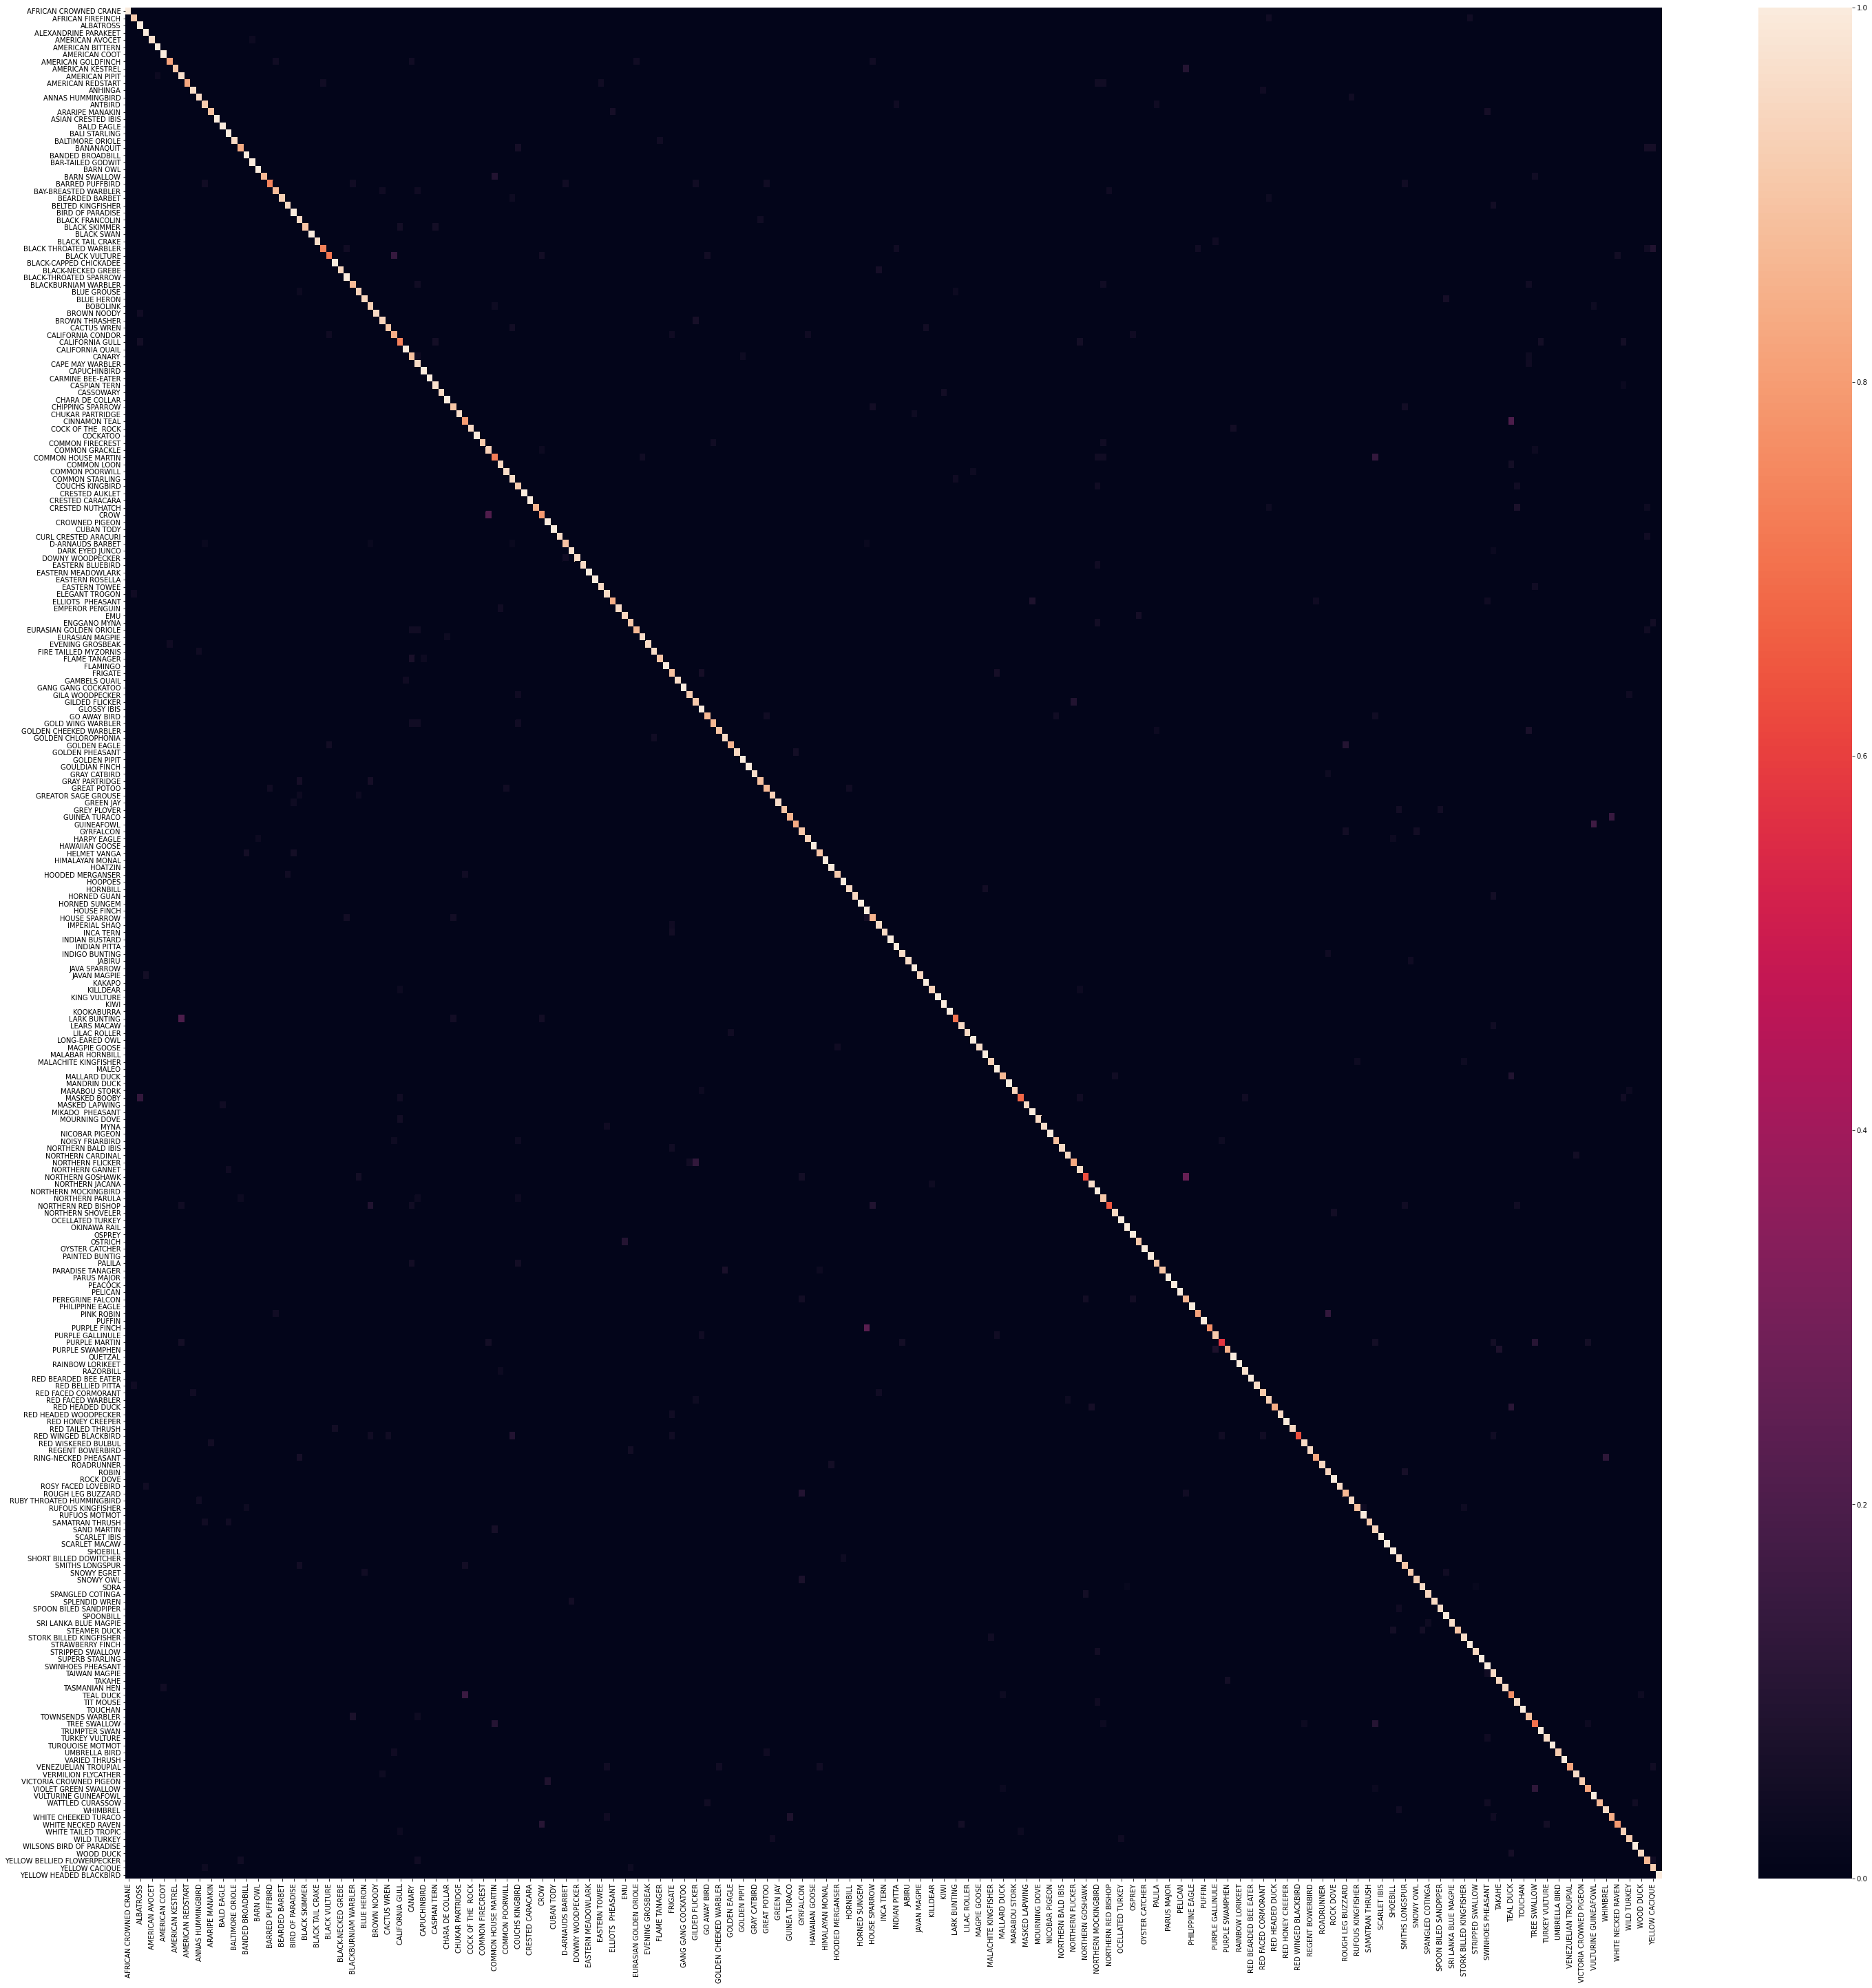

In [143]:
accu, errors = accu(DenseNet['aug'], plt_cm = True)


Enfin nous allons récupérer des images pour lesquels notre modèle s'est trompé ainsi que des images de la vraie classe correspondante. Ce qui nous permettra d'avoir un aperçu des erreurs de notre modèle.  
Nous allons ensuite afficher quelques unes de ces erreurs :

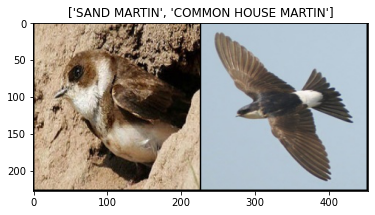

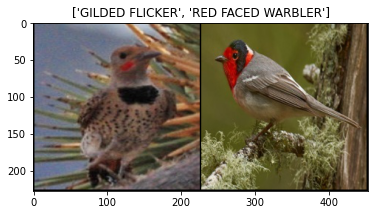

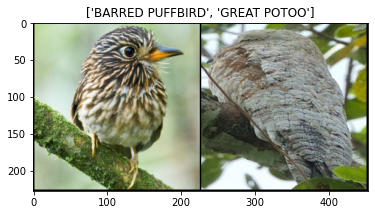

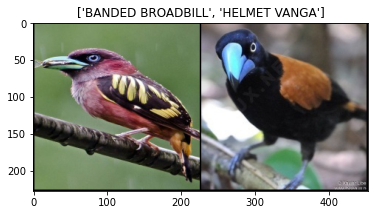

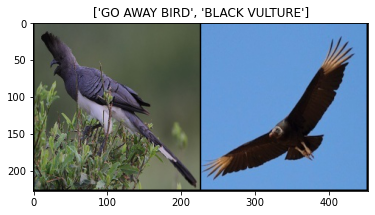

In [189]:
false_image = []
true_image = []
count = 0

for error in errors:
    pred, label = error
    img1 = get_class(pred)
    img2 = get_class(label)
    mistake = (img1, pred)
    true = (img2, label)
    false_image.append(mistake)
    true_image.append(true)
    count+= 1    
    if count == 5:
        break

for i in range(len(false_image)):
    false_img, false_label = false_image[i]
    true_img, true_label = true_image[i]
    grid = torchvision.utils.make_grid([false_img, true_img])
    imshow(grid, title = [class_names[x] for x in [false_label, true_label]])
